In [1]:
# Purpose: Plotting the accumulated ocean heat content and net surface 
#          heating anomalies to see where ocean takes up heat and where it
#          stores it
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ #                         
#     Maurice F. Huguenin, m.huguenin-virchaux@unsw.edu.au, 12. 08. 2020      #                                                
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ #

# % preamble ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ #                         
base = '/g/data/e14/mv7494/access-om2/archive/'
save = '/g/data/e14/mv7494/HeatDist_figures/'

import xarray as xr # for working with labelled multi-dimensional arrays                                                                
import numpy as np # for numerical operations                                                           
import cmocean as cm
from datetime import datetime # package for printing time in plot                                       
import string # for subplot annotation                                                                  
import matplotlib.pyplot as plt # for matlab-like plotting                                              
import cartopy.crs as ccrs # for maps     
import itertools
import cosima_cookbook as cc
import cartopy.mpl.ticker as cticker
import string # for subplot annotation
import cartopy.feature as cfeature
from matplotlib import gridspec
from matplotlib.patches import Rectangle
import matplotlib.patheffects as PathEffects
from scipy import stats
from wrf import to_np # conversion to arrays required for arrows on maps                                

import warnings
warnings.filterwarnings('ignore') # suppress warnings
from matplotlib import ticker
import nc_time_axis
import cftime


from cdo import *
cdo = Cdo()
import os
import sys

# for displaying multiple output in one cell
from IPython.display import display as dp

# colours                                                                                               
# ------------------------------------------------------------------------------------------------------------- #
#  ----                                 Colours from the RdBu_r colour bar                                  ---- #
dark_red   = [.40,.00,.12];   light_red = [.93,.58,.45]; dark_red2 =   [.76,.21,.22]; light_red2 = [.97,.72,.6 ] #
light_blue = [.49,.72,.84];   dark_blue = [.02,.19,.38]; light_blue2 = [.18,.47,.71]; dark_blue2 = [.53,.75,.85] #
# ----------------------------------------------------------------------------------- -------------------------- #
rotblau = [[0.4 , 0.  , 0.12], [0.47, 0.02, 0.13], [0.62, 0.07, 0.16], [0.66, 0.16, 0.2],
           [0.8 , 0.3 , 0.27], [0.87, 0.44, 0.35], [0.93, 0.58, 0.45], [0.96, 0.7 , 0.58], 
           [0.98, 0.8 , 0.71], [0.98, 0.94, 0.92], [0.93, 0.95, 0.96], [0.85, 0.91, 0.95],
           [0.76, 0.87, 0.93], [0.64, 0.8 , 0.89], [0.49, 0.72, 0.84], [0.34, 0.62, 0.79], 
           [0.23, 0.53, 0.74], [0.16, 0.44, 0.7] , [0.1 ,0.35, 0.6], [0.05, 0.24, 0.45], [0.02, 0.19, 0.38]]

from dask.distributed import Client
client = Client(n_workers=16)
client

Client Scheduler: tcp://127.0.0.1:37175 Dashboard: /proxy/41939/status,Cluster Workers: 16 Cores: 16 Memory: 250.00 GiB


### Panel (III): Calculate linear temperature trend for all the ACCESS-OM2-1 simulations

In [2]:
%%time
# with CDO prepare linear trend of temperature values after I have already removed the linear trend 
# in the control simulation
base = '/g/data/e14/mv7494/access-om2/archive/'
#              2006                 2013
start_time = ['1972']; end_time = ['2017']

model = ['ACCESS-OM2-1']#, 'ACCESS-OM2-025']
for i in model: # loop through the two model configurations
    if i == 'ACCESS-OM2-1':
        run = ['1deg_jra55_rdf_branch2000_Control/', '1deg_jra55_rdf_branch2000_Control_PI_Offset/',
               '1deg_jra55_iaf_branch2000/','1deg_jra55_iaf_branch2000_tropics_40SN/','1deg_jra55_iaf_branch2000_extratropics_40SN/',
               '1deg_jra55_iaf_branch2000_Pacific/', '1deg_jra55_iaf_branch2000_Atlantic/', '1deg_jra55_iaf_branch2000_Indian/',
               '1deg_jra55_iaf_branch2000_Southern/', '1deg_jra55_iaf_branch2000_Northern/',
               '1deg_jra55_iaf_branch2000_PI_Offset/',
               '1deg_jra55_iaf_branch2000_Southern_PI_Offset/', '1deg_jra55_iaf_branch2000_Northern_PI_Offset/',
               '1deg_jra55_iaf_branch2000_Tropics30SN_PI_Offset/',
               '1deg_jra55_iaf_branch2000_Pacific_PI_Offset/','1deg_jra55_iaf_branch2000_Indian_PI_Offset/','1deg_jra55_iaf_branch2000_Atlantic_PI_Offset/',
               '1deg_jra55_iaf_branch2000_Wind_PI_Offset/','1deg_jra55_iaf_branch2000_TempRad_PI_Offset/',
               '1deg_jra55_iaf_branch2000_TempRad_PI_Offset_prra_prsn/']
        out = '1deg_jra55_iaf_branch2000_trend/'
        exp = ['clim','clim_PI_Offset','iaf','iaf_tropics_40SN','iaf_extratropics_40SN', 'iaf_Pacific', 'iaf_Atlantic', 'iaf_Indian', 
               'iaf_Southern', 'iaf_Northern', 'iaf_PI_Offset', 'iaf_Southern_PI_Offset', 'iaf_Northern_PI_Offset', 'iaf_Tropics30SN_PI_Offset',
               'iaf_Pacific_PI_Offset', 'iaf_Indian_PI_Offset','iaf_Atlantic_PI_Offset',
               'iaf_Wind_PI_Offset', 'iaf_TempRad_PI_Offset', 'iaf_TempRad_prra_prsn_PI_Offset']

    # merging CTRL output, selecting the years 1972-2017 and selecting temp

    for c in [1]:#range(2): # loop through the two control simulations, iaf_Control and iaf_Control_PI_Offset
        print(run[c])
        # select temp, years and create linear trend from that data
        cdo.selvar('temp', input = '-selyear,'+start_time[0]+'/'+end_time[0]+
                   ' -yearmean -mergetime ' + base + run[c] + 'output*/ocean/ocean.nc',
                   output = base + out + 'temp_'+exp[c]+'_ocean_'+start_time[0]+'-'+end_time[0]+'.nc', force=False)
        cdo.trend(input='-selyear,'+start_time[0]+'/'+end_time[0]+' '+
                  base + out + 'temp_'+exp[c]+'_ocean_'+start_time[0]+'-'+end_time[0]+'.nc',
                  output= base + out + 'intercept_temp_'+exp[c]+'_'+start_time[0]+'-'+end_time[0]+'.nc '+
                  base + out + 'trend_temp_'+exp[c]+'_'+start_time[0]+'-'+end_time[0]+'.nc',force=False)    
    print('-------------------------------------------'); print(' ') # print output to see the progress of the calculations
    # Walltime: 34 min for one control run if files do not already exist
    

    for e in [10,11,12,13,14,15,16,17,18,19]:#range(2,len(run)): # loop through the experiments while skipping the two CTRL runs:
                                # IAF Full, IAF Tropics30SN, IAF Extratropics30SN, IAF Pacific, etc.


        if e > 1 and e < 10: # if the simulation is not either of the two control runs
                             # and is not a PI_Offset hindcast simulation
            print('In this part of the loop, clim gets removed')
            print(run[e])
            print('-------------------------------------------')
            ctrl_run = exp[0] # clim
        if e > 1 and e > 9:
            print('In this part of the loop, clim_PI_Offset gets removed')
            print(run[e])
            print('-------------------------------------------')
            ctrl_run = exp[1] # clim_PI_Offset                   

            

        # (I) merging IAF output, selecting the years 1972-2017 and selecting temp
        cdo.selvar('temp', input = '-selyear,'+start_time[0]+'/'+end_time[0]+
                   ' -yearmean -mergetime ' + base + run[e] + 'output*/ocean/ocean.nc',
                   output = base + out + 'temp_'+exp[e]+'_ocean_'+start_time[0]+'-'+end_time[0]+'.nc', force=False)
        # Walltime: 2min 34s

        # (III) removing the linear trend in the CTRL from the IAF data
        #       -> cdo subtrend ifile afile bfile ofile
        cdo.subtrend(input= base + out + 'temp_'+exp[e]+'_ocean_'+start_time[0]+'-'+end_time[0]+'.nc '+
                     base + out + 'intercept_temp_'+ctrl_run+'_'+start_time[0]+'-'+end_time[0]+'.nc '+
                     base + out + 'trend_temp_'+ctrl_run+'_'+start_time[0]+'-'+end_time[0]+'.nc',
                     output= base + out + 'temp_'+exp[e]+'_ocean_'+start_time[0]+'-'+end_time[0]+'_clim_trend_removed.nc', force=False)
        # Walltime: 24 s

        # (IV) creating intercept and linear trend from the data in step III over different time periods
        for f in range(1): # for full loop: f in range(4): cycles over 1972-2017, 2006-2013,1993-2017 and 2006-2017 periods
            os.system('rm -r '+base + out + 'trend_temp_'+exp[e]+'_'+start_time[f]+'-'+end_time[f]+'.nc')
            cdo.trend(input='-selyear,'+start_time[f]+'/'+end_time[f]+' '+
                      base + out + 'temp_'+exp[e]+'_ocean_'+start_time[0]+'-'+end_time[0]+'_clim_trend_removed.nc',
                      output= base + out + 'intercept_temp_'+exp[e]+'_'+start_time[f]+'-'+end_time[f]+'.nc '+
                      base + out + 'trend_temp_'+exp[e]+'_'+start_time[f]+'-'+end_time[f]+'.nc',force=False)

        if exp[e] != 'iaf': # remove all intercepts except for the iaf simulation. I need this one later on for the check
            os.system('rm -r '+base + out + 'intercept_temp_'+exp[e]+'_'+start_time[f]+'-'+end_time[f]+'.nc')

# Total wall time for a new experiment in ACCESS-OM2-1: 35min 34s
# Wall time: 2min 5s # for rerun

1deg_jra55_rdf_branch2000_Control_PI_Offset/
-------------------------------------------
 
In this part of the loop, clim_PI_Offset gets removed
1deg_jra55_iaf_branch2000_PI_Offset/
-------------------------------------------
In this part of the loop, clim_PI_Offset gets removed
1deg_jra55_iaf_branch2000_Southern_PI_Offset/
-------------------------------------------
In this part of the loop, clim_PI_Offset gets removed
1deg_jra55_iaf_branch2000_Northern_PI_Offset/
-------------------------------------------
In this part of the loop, clim_PI_Offset gets removed
1deg_jra55_iaf_branch2000_Tropics30SN_PI_Offset/
-------------------------------------------
In this part of the loop, clim_PI_Offset gets removed
1deg_jra55_iaf_branch2000_Pacific_PI_Offset/
-------------------------------------------
In this part of the loop, clim_PI_Offset gets removed
1deg_jra55_iaf_branch2000_Indian_PI_Offset/
-------------------------------------------
In this part of the loop, clim_PI_Offset gets removed


### Here specify for which experiment to create the figure

In [3]:

# -------------------------------------------------------------------------------------------------------------------- #
print('--- --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- ---')   #
run    = ['1deg_jra55_rdf_branch2000_Control_PI_Offset/','1deg_jra55_iaf_branch2000_Atlantic_PI_Offset/']
                                                       # '1deg_jra55_iaf_branch2000_Pacific_PI_Offset/'                #
                                                       # '1deg_jra55_iaf_branch2000_Indian_PI_Offset/'                 #
                                                       # '1deg_jra55_iaf_branch2000_Atlantic_PI_Offset/'               #
                                                       # '1deg_jra55_iaf_branch2000_Tropics30SN_PI_Offset/'            #
                                                       # '1deg_jra55_iaf_branch2000_Southern_PI_Offset/'               #
                                                       # '1deg_jra55_iaf_branch2000_Northern_PI_Offset/'               #

exp    = ['ctrl_PI_Offset','iaf_Atlantic_PI_Offset']
                         # 'iaf_Pacific_PI_Offset'                                                                     #
                         # 'iaf_Indian_PI_Offset'                                                                      #
                         # 'iaf_Atlantic_PI_Offset'                                                                    #
                         # 'iaf_Tropics30SN_PI_Offset'                                                                 #
                         # 'iaf_Southern_PI_Offset'                                                                    #
                         # 'iaf_Northern_PI_Offset'                                                                    #
                        
supertitel = 'Atlantic Ocean-only'                                                                                     #
            # 'Pacific Ocean-only'                                                                                     #
            # 'Indian Ocean-only'                                                                                      #
            # 'Atlantic Ocean-only'                                                                                    #
            # 'Tropics-only 30°S-30°N'                                                                                 #
            # 'Southern Ocean-only'                                                                                    #
            # 'Mid and High Northern Latitudes-only'                                                                   #
            
base   = '/g/data/e14/mv7494/access-om2/archive/'                                                                      #
out    = '1deg_jra55_iaf_branch2000_trend/'                                                                            #
print('Creating the full Figure with data from:             ' + run[1])                                                #
print('--- --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- ---')   #
# ----------------------------------------------------------------------------------------------------------           #


--- --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- ---
Creating the full Figure with data from:             1deg_jra55_iaf_branch2000_Atlantic_PI_Offset/
--- --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- --- ---


### Panel (II): Calculate OHC from linear temperature trend

In [4]:
%%time
file = 'trend_temp_clim_PI_Offset_1972-2017.nc'
start_time = ['1972']; end_time = ['2017']
dzt = xr.open_mfdataset(base+run[0]+'output*/ocean/ocean.nc',decode_times=True).dzt.sel(time = slice('1972-01','2017-12')) 
area_t = xr.open_dataset(base+run[0]+'output200/ocean/ocean_grid.nc').area_t
dxt = xr.open_dataset(base+run[0]+'output200/ocean/ocean_grid.nc').dxt
dyt = xr.open_dataset(base+run[0]+'output200/ocean/ocean_grid.nc').dyt
rho_0 = 1035.0                       # [kg m^{-3}]
C_p = 3992.10322329649               # [J kg^{-1} K^{-1}]

# print(exp[1])
temp_access = xr.open_dataset(base+out+'trend_temp_'+exp[1]+'_'+start_time[0]+'-'+end_time[0]+'.nc').temp
OHC_1deg_map      = (rho_0*C_p*temp_access*dzt[0,:,:]).sum(['time','st_ocean']) # units of (J m-2 year-1)
# Wall time: 665 ms

CPU times: user 1.25 s, sys: 215 ms, total: 1.46 s
Wall time: 1.61 s


### Panel (I): Calculating the time-integrated linear net surface heating trend

In [5]:
%%time
# with CDO prepare linear trend of temperature values after I have already removed the linear trend 
# in the control simulation
base = '/g/data/e14/mv7494/access-om2/archive/'

start_time = ['1972']; end_time = ['2017']

model = ['ACCESS-OM2-1']#, 'ACCESS-OM2-025']
for i in model: # loop through the two model configurations

    for f in [0,1]:#range(7): # range(7) for all experiments, range(2) for only iaf and ctrl run
        print(run[f])
    # (I) multiply the net_sfc_heating with the agerage_DT (average time step) time series
        net_sfc_heating = xr.open_mfdataset(base+run[f]+'output*/ocean/ocean_month.nc').net_sfc_heating
        frazil_3d_int_z = xr.open_mfdataset(base+run[f]+'output*/ocean/ocean_month.nc').frazil_3d_int_z
        average_DT = xr.open_mfdataset(base+run[f]+'output*/ocean/ocean_month.nc').average_DT       
        
        # add frazil diagnostics, i.e. heat flux between sea ice and ocean to the net surface heating flux
        # -> it is part of Qnet but output separately
        a = ((net_sfc_heating+frazil_3d_int_z)*60*60*24*30) # multiply by average time period between each time step
        a = a.sel(time=slice(start_time[0]+'-01',end_time[0]+'-12'))
        a = a.cumsum(['time']) # take cumulative sum
        a = a.to_dataset(name='net_sfc_heating')
       
    # (II) save as netcdf file
        # delete file if it already exists, to be sure I do not mess up by potentially overwriting
        os.system('rm -r '+base+out+'net_sfc_heating_average_DT_mergetime_'+start_time[0]+'-'+end_time[0]+'.nc') 
        a.to_netcdf(base+out+'net_sfc_heating_average_DT_'+exp[f]+'_'+start_time[0]+'-'+end_time[0]+'.nc')
        
    # (IV) calculate linear trend in the control
        cdo.trend(input  = base+out+'net_sfc_heating_average_DT_'+exp[0]+'_'+start_time[0]+'-'+end_time[0]+'.nc',
                  output = base+out+'intercept_net_sfc_heating_average_DT_'+exp[0]+'_'+start_time[0]+'-'+end_time[0]+'.nc '+
                  base+out+'trend_net_sfc_heating_average_DT_'+exp[0]+'_'+start_time[0]+'-'+end_time[0]+'.nc', force=False)
        # Wall time: 20.2 s

    # (V) removing the linear trend in the CTRL from the IAF data
        #       -> cdo subtrend ifile afile bfile ofile

        if f > 0: # only remove trend in the loop is over iaf, Pacific, Atlantic or Indian Ocean
            cdo.subtrend(input = base+out+'net_sfc_heating_average_DT_'+exp[f]+'_'+start_time[0]+'-'+end_time[0]+'.nc '+
                         base+out+'intercept_net_sfc_heating_average_DT_'+exp[0]+'_'+start_time[0]+'-'+end_time[0]+'.nc '+
                         base+out+'trend_net_sfc_heating_average_DT_'+exp[0]+'_'+start_time[0]+'-'+end_time[0]+'.nc',
                         output= base+out+'net_sfc_heating_average_DT_'+exp[f]+'_'+
                         start_time[0]+'-'+end_time[0]+'_clim_trend_removed.nc', force=False)
            # Wall time: 1.74 s

        # (VI) creating intercept and linear trend from the data in step  V
        # remove if files already exist
            os.system('rm -r '+base+out+'intercept_net_sfc_heating_average_DT_'+exp[f]+'_'+start_time[0]+'-'+end_time[0]+'_clim_trend_removed.nc ' +
                     base+out+'trend_net_sfc_heating_average_DT_'+exp[f]+'_'+start_time[0]+'-'+end_time[0]+'_clim_trend_removed.nc')
            cdo.trend(input= '-yearmean '+base+out+'net_sfc_heating_average_DT_'+exp[f]+'_'+start_time[0]+'-'+end_time[0]+'_clim_trend_removed.nc',
                      output = base+out+'intercept_net_sfc_heating_average_DT_'+exp[f]+'_'+start_time[0]+'-'+end_time[0]+'_clim_trend_removed.nc '+
                      base+out+'trend_net_sfc_heating_average_DT_'+exp[f]+'_'+start_time[0]+'-'+end_time[0]+'_clim_trend_removed.nc', force=False)
            # clean up
            if exp[f] != 'iaf': # I need the 'iaf' intercept for the calculation check later on
                os.system('rm -r '+base+out+'intercept_net_sfc_heating_average_DT_'+exp[f]+'_'+start_time[0]+'-'+end_time[0]+'_clim_trend_removed.nc')
            # Wall time: 1.56 s

        # Total wall time for ACCESS-OM2-1: 11min 40s
        #                                   3min 39s for a rerun if files already exist
            if f > 0:
                Qnet_1deg_map = xr.open_dataset(base+out+'trend_net_sfc_heating_average_DT_'+exp[f]+'_'+start_time[0]+'-'+end_time[0]+'_clim_trend_removed.nc').net_sfc_heating[0,:,:]
# Wall time: 15.6 s

1deg_jra55_rdf_branch2000_Control_PI_Offset/
1deg_jra55_iaf_branch2000_Atlantic_PI_Offset/
CPU times: user 6.89 s, sys: 896 ms, total: 7.79 s
Wall time: 53.5 s


### Panel (I): Check with global time series

CPU times: user 13.1 s, sys: 4.47 s, total: 17.6 s
Wall time: 38.8 s


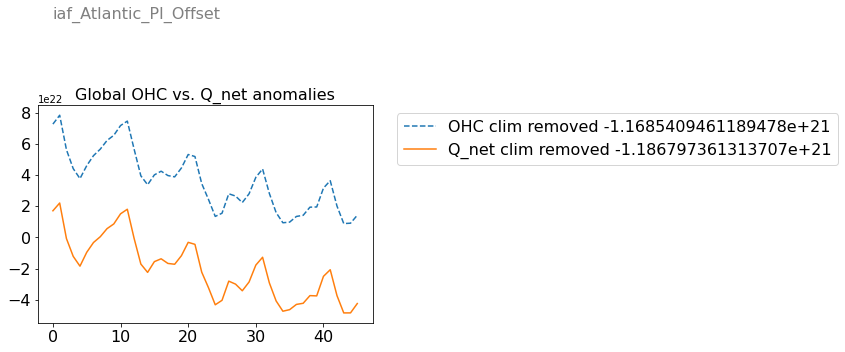

In [6]:
%%time
base = '/g/data/e14/mv7494/access-om2/archive/'
out = '1deg_jra55_iaf_branch2000_trend/'

# Wichtig! Hier nicht vergessen dass ich die Analyse für den PI_Offset spin-up mache #                                                               #
# ---------------------------------------------------------------------------------- #

# --- ocean heat content anomalies
dzt = xr.open_mfdataset(base+run[1]+'output*/ocean/ocean.nc',decode_times=True).dzt.sel(time = slice('1972-01','2017-12')) 
area_t = xr.open_dataset(base+run[1]+'output200/ocean/ocean_grid.nc').area_t
rho_0 = 1035.0                       # [kg m^{-3}]
C_p = 3992.10322329649               # [J kg^{-1} K^{-1}]
temp_access = xr.open_dataset(base+out+'temp_' + exp[1] + '_ocean_1972-2017_clim_trend_removed.nc').temp
OHC = (rho_0*C_p*temp_access*dzt).sum(['st_ocean'])
OHC_1deg_global      = (OHC*area_t).sum(['xt_ocean','yt_ocean']) # units of (J m-2 year-1)

# --- net surface heating anomalies

Qnet = xr.open_dataset(base+out+'net_sfc_heating_average_DT_' + exp[1] + '_1972-2017_clim_trend_removed.nc',decode_times=True).groupby('time.year').mean('time').net_sfc_heating
Qnet_1deg_global = (Qnet*area_t).sum(['xt_ocean','yt_ocean'])


# --- quick plot
z = np.polyfit(np.linspace(1,46,46),OHC_1deg_global.values, 1); poly1 = np.poly1d(z) # get the linear trends
z = np.polyfit(np.linspace(1,46,46),Qnet_1deg_global.values, 1); poly2 = np.poly1d(z)
plt.plot(OHC_1deg_global.values,label='OHC clim removed '+str(poly1[1]), linestyle='dashed')
plt.plot(Qnet_1deg_global.values,label='Q_net clim removed '+str(poly2[1]))
plt.xticks(fontsize=16); plt.yticks(fontsize=16); plt.title('Global OHC vs. Q_net anomalies', fontsize=16)
plt.text(0,1.4e23,exp[1], fontsize=16, c = 'grey')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=16)
plt.savefig(save + 'Global_OHC_vs_Qnet_anoms_'+exp[1])
# Wall time: 15.7 s -> ok, all looks okay

### Panel (IV): mean SAT-SST differences

CPU times: user 1.91 s, sys: 701 ms, total: 2.61 s
Wall time: 13.8 s


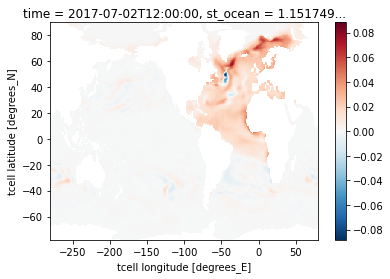

In [7]:
%%time

# (I) - mergetime, select years and calculate monthly means
# ---------------------------------
base_jra_sat = '/g/data/qv56/replicas/input4MIPs/CMIP6/OMIP/MRI/MRI-JRA55-do-1-3/atmos/3hrPt/tas/gn/v20180412/'
base_jra_seaice = '/g/data/qv56/replicas/input4MIPs/CMIP6/OMIP/MRI/MRI-JRA55-do-1-3/seaIce/3hrPt/siconca/gn/v20180412/'

base_out_jra = '/g/data/e14/mv7494/jra55-do/'
# (I) mergetime, selyear and monmean for SAT, SST and SICONCA
# cdo.monmean(input = '-selyear,1958/2017 -mergetime ' + base_jra_sat+'tas_input4MIPs_atmosphericState_OMIP_MRI-JRA55-do-1-3_gn_*.nc',
#             output = base_out_jra + 'JRA55-do_SAT_'+exp+'_monmean_1958-2017.nc', force=False)
# cdo.monmean(input = '-selyear,1958/2017 -selvar,temp -mergetime ' + base+run[0]+'output*/ocean/ocean_month.nc',
#             output = base + out + 'ACCESS-OM2-1_SST_'+exp+'_monmean_1958-2017.nc', force=False)
cdo.monmean(input = '-selyear,1958/2017 -mergetime '+base_jra_seaice+'siconca_input4MIPs_atmosphericState_OMIP_MRI-JRA55-do-1-3_gn_*.nc',
            output = base_out_jra + 'JRA55-do_SICONCA_monmean_1958-2017.nc', force=False)

# (II) create anomalies for SAT and SST: cdo -yseassub ifile.nc -yseasavg ifile.nc ofile.nc
# cdo.yseassub(input = base_out_jra + 'JRA55-do_SAT_'+exp+'_monmean_1958-2017.nc -yseasavg ' + base_out_jra + 'JRA55-do_SAT_'+exp+'_monmean_1958-2017.nc',
#             output = base_out_jra + 'JRA55-do_SAT_'+exp+'_anom_1958-2017.nc', force=False)
# cdo.yseassub(input = base + out + 'ACCESS-OM2-1_SST_'+exp+'_monmean_1958-2017.nc -yseasavg ' + base + out + 'ACCESS-OM2-1_SST_'+exp+'_monmean_1958-2017.nc',
#             output = base + out + 'ACCESS-OM2-1_SST_'+exp+'_anom_1958-2017.nc', force=False)
# (II) - remap to ACCESS-OM2-1 grid
# ---------------------------------
# --- remap to ACCESS-OM2-1 grid
# cdo.remapbil(base + run[0] + '/output201/ocean/ocean_grid.nc', input = base_out_jra + 'JRA55-do_SAT_anom_1958-2017.nc',
#             output = base_out_jra + 'JRA55-do_SAT_monthly_anom_1958-2017_remapped.nc', force=False)
cdo.remapbil(base + run[0] + '/output201/ocean/ocean_grid.nc', input = base_out_jra + 'JRA55-do_SICONCA_monmean_1958-2017.nc',
            output = base_out_jra + 'JRA55-do_SICONCA_monthly_mean_1958-2017_remapped.nc', force=False)
# Wall time: 20.7 s

# (II) - create a mask out of the sea ice concentration data: 1 when siconca < 15%, 0 when siconca > 15%
# ---------------------------------
siconca = xr.open_mfdataset(base_out_jra + 'JRA55-do_SICONCA_monthly_mean_1958-2017_remapped.nc').siconca
siconca = siconca.where(siconca > 15,1) # here replace sea ice concentration above 15% with zeroes and below 15% with ones 
siconca = siconca.where(siconca < 15,0) # these commands are correct but why do I need to use the opposite?!

siconca_masked = siconca.where(siconca != 0) # replace all values equal to 0 with np.nan


os.system('rm -r '+ base_out_jra + 'siconca_jra55-do_mask.nc')
siconca.to_dataset(name='siconca_jra_mask').to_netcdf(base_out_jra + 'siconca_jra55-do_mask.nc') # save as .netcdf file
# Wall time: 2.14 s

siconca = xr.open_mfdataset(base_out_jra + 'siconca_jra55-do_mask.nc').siconca_jra_mask.sel(time = slice('1972-01','2017-12'))
# sat_jra_remapped = xr.open_mfdataset(base_out_jra + 'JRA55-do_SAT_monthly_anom_1958-2017_remapped.nc').tas.sel(time = slice('1972-01','2017-12'))

# sst_access = xr.open_mfdataset(base + out + 'ACCESS-OM2-1_SST_anom_1958-2017.nc').sel(time=slice('1972-01','2017-12')).temp[:,0,:,:]
# sat_jra_remapped['time'] = sst_access.time; siconca['time'] = sst_access.time

# SAT_SST_diff = siconca.mean('time')*(sat_jra_remapped-sst_access).mean('time')


temp_access = xr.open_dataset(base+out+'trend_temp_'+exp[1]+'_1972-2017.nc').temp[0,0,:,:]
SST_trend = temp_access*siconca.mean('time')
SST_trend.plot()
# Wall time: 2.98 s

### Preparing the basin-masks

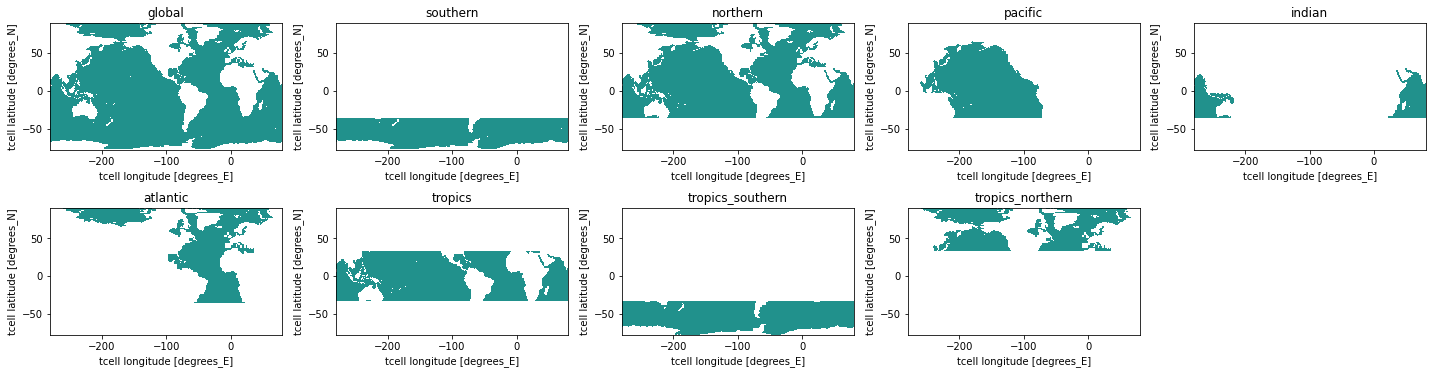

In [8]:
#### %%time
index = 1

# ---- define the southern boundary of the masks ---- #
if exp[1] == 'iaf_Pacific_PI_Offset': # For the Pacific-only IAF experiment, I apply IAF down to 44.5°S with the smoothing region to 40°S
    south_bound = -42.5               # This is to avoid forcing the shallow overturning cells with a combination of IAF and RDF
else:
    south_bound = -36 # For all other experiments in this script, the southern boundary is at 26°S, i.e., at the southern tip of Africa


fig = plt.figure(figsize=(20,10),tight_layout=True,facecolor='w',edgecolor='k')
titel = ['global','southern','northern','pacific','indian', 'atlantic', 'tropics', 'tropics_southern', 'tropics_northern']
for b in range(9):
    basin_mask = xr.open_mfdataset('/g/data/ik11/inputs/access-om2/input_236a3011/mom_1deg/basin_mask.nc').BASIN_MASK
    basin_mask = basin_mask.where(basin_mask != 4,2) # replace Arctic Ocean index values (i.e. 4) with 2
    basin_mask = basin_mask.where(basin_mask != 6,2) # add Mediterranean Sea to Atlantic Ocean
    basin_mask = basin_mask.where(basin_mask != 8,2) # add Hudson Bay to Atlantic Ocean
    basin_mask = basin_mask.where(basin_mask != 9,2) # add Baltic Sea to Atlantic Ocean
    basin_mask = basin_mask.where(basin_mask != 10,5) # add Red Sea to Indian Ocean
    basin = basin_mask.where(basin_mask == index) # only select one basin & squeeze to get rid of one dim

    if b == 0: # mask for GLOBAL
        for f in range(10): # replacing all the ocean with '1' values
            basin_mask = basin_mask.where(basin_mask != f+1,1) # 
        basin = basin_mask.where(basin_mask == 1) # only select one basin & squeeze to get rid of one dim
        basin = basin.where(np.isnan(basin),1) # replace that specific basin with 1, the rest will be NaNs
    if b == 1: # mask for SOUTHERN
        for f in range(10): # replacing all the ocean with '1' values
            basin_mask = basin_mask.where(basin_mask != f+1,1) # 
        basin_mask = basin_mask.where((basin_mask.YT_OCEAN<south_bound) | (basin_mask.XT_OCEAN<-280) | (basin_mask.XT_OCEAN>80), 0) 
        basin = basin_mask.where(basin_mask == 1) # only select one basin & squeeze to get rid of one dim
        basin = basin.where(np.isnan(basin),1) # replace that specific basin with 1, the rest will be NaNs
    if b == 2: # mask for NORTHERN
        for f in range(10): # replacing all the ocean with '1' values
            basin_mask = basin_mask.where(basin_mask != f+1,1) # 
        basin_mask = basin_mask.where((basin_mask.YT_OCEAN>south_bound) | (basin_mask.XT_OCEAN<-280) | (basin_mask.XT_OCEAN>80), 0) 
        basin = basin_mask.where(basin_mask == 1) # only select one basin & squeeze to get rid of one dim
        basin = basin.where(np.isnan(basin),1) # replace that specific basin with 1, the rest will be NaNs 
    if b == 3:
        basin_mask = basin_mask.where(basin_mask != 1,3) # remove the Indian Ocean again
        basin_mask = basin_mask.where(basin_mask == 3) # only select one basin & squeeze to get rid of one dim
        basin_mask = basin_mask.where((basin_mask.XT_OCEAN<-69) | np.isnan(basin_mask), 0) 
        basin_mask = basin_mask.where((basin_mask.YT_OCEAN<-90) | (basin_mask.YT_OCEAN>-30) | (basin_mask.XT_OCEAN<-280) | (basin_mask.XT_OCEAN>-220) | np.isnan(basin_mask), 0) 
        basin_mask = basin_mask.where(basin_mask != 3,1) #
        basin_mask = basin_mask.where((basin_mask.YT_OCEAN<-90) | (basin_mask.YT_OCEAN>-38) | (basin_mask.XT_OCEAN<-280) | (basin_mask.XT_OCEAN>-210), 0)
        basin_mask = basin_mask.where((basin_mask.YT_OCEAN>south_bound) | (basin_mask.XT_OCEAN<-280) | (basin_mask.XT_OCEAN>80), 0) # cut off extratropics north and south of 44°S/N
        basin = basin_mask.where(basin_mask == 1) # only select one basin & squeeze to get rid of one dim
    
    if b == 4:
        basin_mask = basin_mask.where(basin_mask != 1,5) #
        basin_mask = basin_mask.where(basin_mask == 5) # only select one basin & squeeze to get rid of one dim
        basin_mask = basin_mask.where((basin_mask.YT_OCEAN<-90) | (basin_mask.YT_OCEAN>-30) | (basin_mask.XT_OCEAN<-220) | (basin_mask.XT_OCEAN>-69) | np.isnan(basin_mask), 0) 
        basin_mask = basin_mask.where((basin_mask.YT_OCEAN<-90) | (basin_mask.YT_OCEAN>-30) | (basin_mask.XT_OCEAN<-69) | (basin_mask.XT_OCEAN>22) | np.isnan(basin_mask), 0) 
        basin_mask = basin_mask.where(basin_mask !=5,1) #
        basin_mask = basin_mask.where((basin_mask.YT_OCEAN>south_bound) | (basin_mask.XT_OCEAN<-280) | (basin_mask.XT_OCEAN>80), 0) # cut off extratropics north and south of 42.5°S/N
        basin_mask = basin_mask.where((basin_mask.YT_OCEAN<42.5) | (basin_mask.XT_OCEAN<-280) | (basin_mask.XT_OCEAN>80), 0) 
        basin = basin_mask.where(basin_mask == 1) # only select one basin & squeeze to get rid of one dim
    if b == 5:
        basin_mask = basin_mask.where(basin_mask != 1,2) #
        basin_mask = basin_mask.where(basin_mask == 2) # only select one basin & squeeze to get rid of one dim
        basin_mask = basin_mask.where((basin_mask.YT_OCEAN<-90) | (basin_mask.YT_OCEAN>-30) | (basin_mask.XT_OCEAN<-280) | (basin_mask.XT_OCEAN>-69) | np.isnan(basin_mask), 0) 
        basin_mask = basin_mask.where((basin_mask.YT_OCEAN<-90) | (basin_mask.YT_OCEAN>-30) | (basin_mask.XT_OCEAN<22) | (basin_mask.XT_OCEAN>80) | np.isnan(basin_mask), 0) 
        basin_mask = basin_mask.where((basin_mask.YT_OCEAN>south_bound) | (basin_mask.XT_OCEAN<-280) | (basin_mask.XT_OCEAN>80), 0) # cut off extratropics north and south of 42.5°S/N
        basin_mask = basin_mask.where(basin_mask !=2,1) #
        basin = basin_mask.where(basin_mask == 1) # only select one basin & squeeze to get rid of one dim 
    if b == 6: # mask for the tropics_30SN
        for f in range(10): # replacing all the ocean with '1' values
            basin_mask = basin_mask.where(basin_mask != f+1,1) # 
            basin_mask = basin_mask.where((basin_mask.YT_OCEAN>-32.5) | (basin_mask.XT_OCEAN<-280) | (basin_mask.XT_OCEAN>80), 0) # cut off extratropics north and south of 42.5°S/N
            basin_mask = basin_mask.where((basin_mask.YT_OCEAN<32.5) | (basin_mask.XT_OCEAN<-280) | (basin_mask.XT_OCEAN>80), 0)             
            basin = basin_mask.where(basin_mask == 1) # only select one basin & squeeze to get rid of one dim
            basin = basin.where(np.isnan(basin),1) # replace that specific basin with 1, the rest will be NaNs
    if b == 7: # mask for TROPICS_SOUTHERN
        for f in range(10): # replacing all the ocean with '1' values
            basin_mask = basin_mask.where(basin_mask != f+1,1) # 
        basin_mask = basin_mask.where((basin_mask.YT_OCEAN<-32.5) | (basin_mask.XT_OCEAN<-280) | (basin_mask.XT_OCEAN>80), 0) 
        basin = basin_mask.where(basin_mask == 1) # only select one basin & squeeze to get rid of one dim
        basin = basin.where(np.isnan(basin),1) # replace that specific basin with 1, the rest will be NaNs
    if b == 8: # mask for TROPICS_NORTHERN
        for f in range(10): # replacing all the ocean with '1' values
            basin_mask = basin_mask.where(basin_mask != f+1,1) # 
        basin_mask = basin_mask.where((basin_mask.YT_OCEAN>32.5) | (basin_mask.XT_OCEAN<-280) | (basin_mask.XT_OCEAN>80), 0) 
        basin = basin_mask.where(basin_mask == 1) # only select one basin & squeeze to get rid of one dim
        basin = basin.where(np.isnan(basin),1) # replace that specific basin with 1, the rest will be NaNs 
    if b == 14: # mask for TROPICS_PACIFIC
        basin_mask = basin_mask.where(basin_mask != 1,3) # remove the Indian Ocean again
        basin_mask = basin_mask.where(basin_mask == 3) # only select one basin & squeeze to get rid of one dim
        basin_mask = basin_mask.where((basin_mask.XT_OCEAN<-69) | np.isnan(basin_mask), 0) 
        basin_mask = basin_mask.where((basin_mask.YT_OCEAN<-90) | (basin_mask.YT_OCEAN>-30) | (basin_mask.XT_OCEAN<-280) | (basin_mask.XT_OCEAN>-220) | np.isnan(basin_mask), 0) 
        basin_mask = basin_mask.where(basin_mask != 3,1) #
        basin_mask = basin_mask.where((basin_mask.YT_OCEAN>-32.5) | (basin_mask.XT_OCEAN<-280) | (basin_mask.XT_OCEAN>80), 0) # cut off extratropics north and south of 42.5°S/N
        basin_mask = basin_mask.where((basin_mask.YT_OCEAN<32.5) | (basin_mask.XT_OCEAN<-280) | (basin_mask.XT_OCEAN>80), 0) 
        basin = basin_mask.where(basin_mask == 1) # only select one basin & squeeze to get rid of one dim
    if b == 15: # mask for TROPICS_INDIAN
        basin_mask = basin_mask.where(basin_mask != 1,5) #
        basin_mask = basin_mask.where(basin_mask == 5) # only select one basin & squeeze to get rid of one dim
        basin_mask = basin_mask.where((basin_mask.YT_OCEAN<-90) | (basin_mask.YT_OCEAN>-30) | (basin_mask.XT_OCEAN<-220) | (basin_mask.XT_OCEAN>-69) | np.isnan(basin_mask), 0) 
        basin_mask = basin_mask.where((basin_mask.YT_OCEAN<-90) | (basin_mask.YT_OCEAN>-30) | (basin_mask.XT_OCEAN<-69) | (basin_mask.XT_OCEAN>22) | np.isnan(basin_mask), 0) 
        basin_mask = basin_mask.where(basin_mask !=5,1) #
        basin_mask = basin_mask.where((basin_mask.YT_OCEAN>-32.5) | (basin_mask.XT_OCEAN<-280) | (basin_mask.XT_OCEAN>80), 0) # cut off extratropics north and south of 42.5°S/N
        basin_mask = basin_mask.where((basin_mask.YT_OCEAN<32.5) | (basin_mask.XT_OCEAN<-280) | (basin_mask.XT_OCEAN>80), 0) 
        basin = basin_mask.where(basin_mask == 1) # only select one basin & squeeze to get rid of one dim
    if b == 16: # mask for TROPICS_ATLANTIC
        basin_mask = basin_mask.where(basin_mask != 1,2) #
        basin_mask = basin_mask.where(basin_mask == 2) # only select one basin & squeeze to get rid of one dim
        basin_mask = basin_mask.where((basin_mask.YT_OCEAN<-90) | (basin_mask.YT_OCEAN>-30) | (basin_mask.XT_OCEAN<-280) | (basin_mask.XT_OCEAN>-69) | np.isnan(basin_mask), 0) 
        basin_mask = basin_mask.where((basin_mask.YT_OCEAN<-90) | (basin_mask.YT_OCEAN>-30) | (basin_mask.XT_OCEAN<22) | (basin_mask.XT_OCEAN>80) | np.isnan(basin_mask), 0) 
        basin_mask = basin_mask.where((basin_mask.YT_OCEAN>-32.5) | (basin_mask.XT_OCEAN<-280) | (basin_mask.XT_OCEAN>80), 0) # cut off extratropics north and south of 42.5°S/N
        basin_mask = basin_mask.where((basin_mask.YT_OCEAN<32.5) | (basin_mask.XT_OCEAN<-280) | (basin_mask.XT_OCEAN>80), 0) 
        basin_mask = basin_mask.where(basin_mask !=2,1) #
        basin = basin_mask.where(basin_mask == 1) # only select one basin & squeeze to get rid of one dim

    basin = basin[0,:,:]    
    plt.subplot(4,5,b+1)
    basin.plot(add_colorbar=False);    plt.title(titel[b])
    if b == 0:        basin_global = basin       # Global Ocean
    if b == 1:        basin_southern = basin     # Southern Ocean
    if b == 2:        basin_northern = basin     # Northern Ocean
    if b == 3:        basin_pacific = basin      # Pacific
    if b == 4:        basin_indian = basin       # Indian 
    if b == 5:        basin_atlantic = basin     # Atlantic
    if b == 6:        basin_tropics = basin      # Tropics
    if b == 7:        basin_tropics_southern = basin 
    if b == 8:        basin_tropics_northern = basin
# Wall time: 1.96 s

### Creating the contours

In [9]:
%%time
dims = [300, 360]
loop = ['--- Tropics ---', '--- Pacific ---', '--- Indian ---', '--- Atlantic ---', '--- Southern ---', '--- Northern ---']
for m in range(6): # loop through the three basins Pacific, Atlantic and Indian Ocean
    if m == 0: a = basin_tropics.fillna(0).drop('ST_OCEAN1_1').squeeze() 
    if m == 1: a = basin_pacific.fillna(0).drop('ST_OCEAN1_1').squeeze() 
    if m == 2: a = basin_indian.fillna(0).drop('ST_OCEAN1_1').squeeze() 
    if m == 3: a = basin_atlantic.fillna(0).drop('ST_OCEAN1_1').squeeze()
    if m == 4: a = basin_southern.fillna(0).drop('ST_OCEAN1_1').squeeze()
    if m == 5: a = basin_northern.fillna(0).drop('ST_OCEAN1_1').squeeze()
        
    print(loop[m])
    # remove data above 65°N as the cartopy projection encounters difficulties plotting the band boundaries up there
#     a = a.where((a.YT_OCEAN<65) | (a.XT_OCEAN<-280) | (basin_mask.XT_OCEAN>80), 1) 
    a = a.values   

    # this below here is super very much inefficient but hey it works! ....takes ages probably as well haha
    for y in range(1,dims[0]-1):
        for x in range(1,dims[1]-1):
            if a[y,x] == 0 and a[y,x+1] == 1: a[y,x] = .8        # western boundary     
            if a[y,x] == 1 and a[y,x+1] == 0: a[y,x+1] = .8      # eastern boundary 
            if a[y,x] == 0 and a[y+1,x] == 1: a[y,x] = .8      # southern boundary
            if a[y,x] == 1 and a[y+1,x] == 0: a[y+1,x] = .8      # northern boundary          
    for y in range(1,dims[0]-1):
        for x in range(1,dims[1]-1):           
            if a[y,x] == 0 and np.round(a[y,x+1]*10,1) == 8: a[y,x] = .6        # western boundary     
            if np.round(a[y,x]*10,1) == 8 and a[y,x+1] == 0: a[y,x+1] = .6      # eastern boundary 
            if a[y,x] == 0 and np.round(a[y+1,x]*10,1) == 8: a[y,x] = .6      # southern boundary
            if np.round(a[y,x]*10,1) == 8 and a[y+1,x] == 0: a[y+1,x] = .6      # northern boundary        
    # the strange work-around with np.round(x*10) is necessary as only True/False statement with integers
    # each time a new loop as else values cannot be overwritten 
    for y in range(1,dims[0]-1):
        for x in range(1,dims[1]-1):
            if a[y,x] == 0 and np.round(a[y,x+1]*10,1) == 6: a[y,x] = .4        # western boundary     
            if np.round(a[y,x]*10,1) == 6 and a[y,x+1] == 0: a[y,x+1] = .4      # eastern boundary 
            if a[y,x] == 0 and np.round(a[y+1,x]*10,1) == 6: a[y,x] = .4      # southern boundary
            if np.round(a[y,x]*10,1) == 6 and a[y+1,x] == 0: a[y+1,x] = .4      # northern boundary
    for y in range(1,dims[0]-1):
        for x in range(1,dims[1]-1):
            if a[y,x] == 0 and np.round(a[y,x+1]*10,1) == 4: a[y,x] = .2        # western boundary     
            if np.round(a[y,x]*10,1) == 4 and a[y,x+1] == 0: a[y,x+1] = .2      # eastern boundary 
            if a[y,x] == 0 and np.round(a[y+1,x]*10,1) == 4: a[y,x] = .2      # southern boundary
            if np.round(a[y,x]*10,1) == 4 and a[y+1,x] == 0: a[y+1,x] = .2      # northern boundary
    # allocate array to name each iteration
    if m == 0: iaf_mask_tropics = a; 
    if m == 1: iaf_mask_pacific = a; 
    if m == 2: iaf_mask_indian = a; 
    if m == 3: iaf_mask_atlantic = a; 
    if m == 4: iaf_mask_southern = a;
    if m == 5: iaf_mask_northern = a;
ds3 = xr.Dataset({'basin_global': basin_global.drop('ST_OCEAN1_1'), 
                  'contour_tropics': (('YT_OCEAN', 'XT_OCEAN'), iaf_mask_tropics),
                  'contour_pacific': (('YT_OCEAN', 'XT_OCEAN'), iaf_mask_pacific),
                  'contour_indian': (('YT_OCEAN', 'XT_OCEAN'), iaf_mask_indian),
                  'contour_atlantic': (('YT_OCEAN', 'XT_OCEAN'), iaf_mask_atlantic),
                  'contour_southern': (('YT_OCEAN', 'XT_OCEAN'), iaf_mask_southern),
                  'contour_northern': (('YT_OCEAN', 'XT_OCEAN'), iaf_mask_northern)}) 
# Wall time: 1min 33s

--- Tropics ---
--- Pacific ---
--- Indian ---
--- Atlantic ---
--- Southern ---
--- Northern ---
CPU times: user 1min 20s, sys: 4.36 s, total: 1min 24s
Wall time: 1min 29s


### fancy_plot() function

In [10]:
def fancy_plot(axes_nr):
    '''
    This function creates my specifics for the global plot, i.e.
    coastlines, land colour, gridlines and labels (30°lat, 60°lon)
    input:
        - axes_nr -> number of subplot, i.e. ax1 for subplot(2,2,1)
    '''
    axes_nr.coastlines(resolution = '50m') # add coast lines
    # ticklabels on left and bottom only
    axes_nr.set_xticks([0,90,180,270,360], crs=ccrs.PlateCarree())   
    axes_nr.set_yticks([-80,-45,0,45,80], crs=ccrs.PlateCarree())
    
    lon_formatter = cticker.LongitudeFormatter();
    lat_formatter = cticker.LatitudeFormatter()
    axes_nr.xaxis.set_major_formatter(lon_formatter) # set format of x-axis
    axes_nr.yaxis.set_major_formatter(lat_formatter) # "       "       "
    axes_nr.add_feature(cfeature.LAND, edgecolor = 'black', facecolor = [.83,.83,.83], zorder = 1)

    axes_nr.xaxis.label.set_visible(False) # no axis labels
    axes_nr.yaxis.label.set_visible(False)

    axes_nr.tick_params(axis='both', which='major', labelsize=16) # fontsize of lon/lat labels

### Checking outlines with cartopy

CPU times: user 6.91 s, sys: 798 ms, total: 7.7 s
Wall time: 7 s


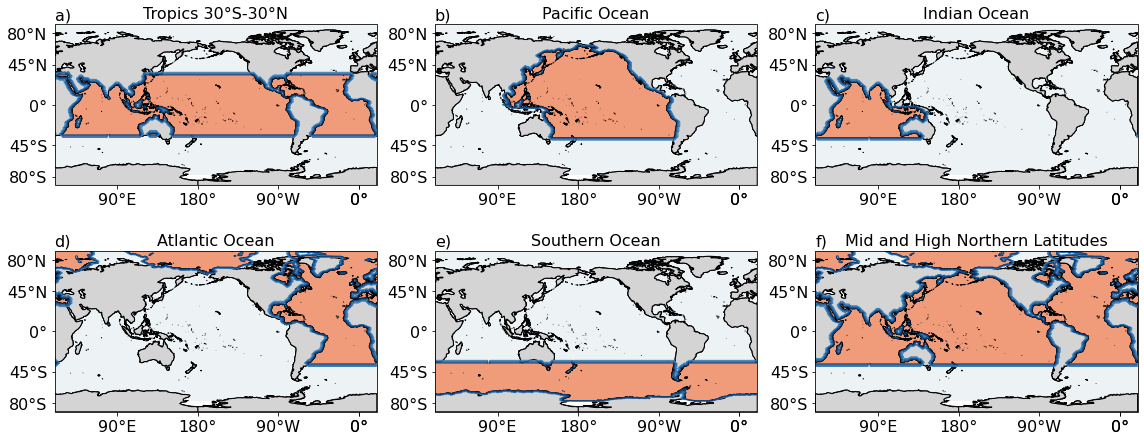

In [11]:
%%time
# farbe = rotblau[0:4] # red contours
farbe = rotblau[16:20] # blue contours

titles = ['Tropics 30°S-30°N', 'Pacific Ocean', 'Indian Ocean', 'Atlantic Ocean', 'Southern Ocean', 'Mid and High Northern Latitudes']
# initialise figure
fig = plt.figure(figsize=(16,8),tight_layout=True,facecolor='w',edgecolor='k')

for f in range(6):
    if f == 0: data = ds3.contour_tropics
    if f == 1: data = ds3.contour_pacific
    if f == 2: data = ds3.contour_indian
    if f == 3: data = ds3.contour_atlantic
    if f == 4: data = ds3.contour_southern
    if f == 5: data = ds3.contour_northern
        
    ax1 = plt.subplot(2,3,f+1, projection=ccrs.PlateCarree(central_longitude=200)) # longitude starting at Cape Agulhas (20°E) 
    ticks = np.linspace(-2,2,num=21) # ticks for colour bar
    ax1.set_extent([1, 360, -90,90], crs=ccrs.PlateCarree())

    p1 = data.plot.contourf(cmp='tab10',levels=ticks, add_colorbar=False,extend='both',transform=ccrs.PlateCarree())
    p22 = data.plot.contour(levels=[.2,.4,.6,.8,1], linewidths=1, colors=farbe, transform=ccrs.PlateCarree())
    plt.title(titles[f], fontsize=16) # title
    ax1.text(0, 1.03,string.ascii_lowercase[f]+')', transform=ax1.transAxes, size=16, weight='normal') # bold letter a at the top
    fancy_plot(ax1) # add land boundaries, fill in land and add labels in °S/°N form
    ax1.add_feature(cfeature.LAND, edgecolor = 'black', facecolor = [.83,.83,.83], zorder = 1) # zorder 1 to plot contours above the filled land area

# --------------------------------------------------------------------------- #
# --- saving as 300 dpi .PNG image in specified folder ---------------------- #
# --- end of script --------------------------------------------------------- #
plt.savefig(save + 'boundaries_north_basin_mask', dpi=300, facecolor='w',  edgecolor='w', orientation='landscape', papertype=None, 
            format=None, transparent=False, bbox_inches='tight', pad_inches=0.1, metadata=None)
# --------------------------------------------------------------------------- #
#Wall time: 5.86 s s

### Calculate basin-wide integrated trends

In [12]:
%%time        
c = basin_southern.values * OHC.values;         d = basin_southern.values * Qnet.values
e = basin_northern.values * OHC.values;         f = basin_northern.values * Qnet.values
g = basin_pacific.values * OHC.values;          h = basin_pacific.values * Qnet.values
i = basin_indian.values * OHC.values;           k = basin_indian.values * Qnet.values
l = basin_atlantic.values * OHC.values;         m = basin_atlantic.values * Qnet.values
n = basin_tropics.values * OHC.values;          o = basin_tropics.values * Qnet.values
p = basin_tropics_southern.values * OHC.values; q = basin_tropics_southern.values * Qnet.values
r = basin_tropics_northern.values * OHC.values; s = basin_tropics_northern.values * Qnet.values

x = OHC.values; y = Qnet.values

ds = xr.Dataset({'OHC': OHC, 
                'OHC_Southern': (('year', 'yt_ocean', 'xt_ocean'), c), # write ocean heat content and ocean heat uptake fields into dataset
                'Qnet_Southern': (('year', 'yt_ocean', 'xt_ocean'), d),
                'OHC_Northern': (('year', 'yt_ocean', 'xt_ocean'), e),
                'Qnet_Northern': (('year', 'yt_ocean', 'xt_ocean'), f),
                 
                'OHC_Pacific': (('year', 'yt_ocean', 'xt_ocean'), g),
                'Qnet_Pacific': (('year', 'yt_ocean', 'xt_ocean'), h),
                'OHC_Indian': (('year', 'yt_ocean', 'xt_ocean'), i),
                'Qnet_Indian': (('year', 'yt_ocean', 'xt_ocean'), k),                 
                'OHC_Atlantic': (('year', 'yt_ocean', 'xt_ocean'), l),
                'Qnet_Atlantic': (('year', 'yt_ocean', 'xt_ocean'), m),                 

                'OHC_Tropics': (('year', 'yt_ocean', 'xt_ocean'), n),
                'Qnet_Tropics': (('year', 'yt_ocean', 'xt_ocean'), o),
                'OHC_Tropics_South': (('year', 'yt_ocean', 'xt_ocean'), p),
                'Qnet_Tropics_South': (('year', 'yt_ocean', 'xt_ocean'), q),                 
                'OHC_Tropics_North': (('year', 'yt_ocean', 'xt_ocean'), r),
                'Qnet_Tropics_North': (('year', 'yt_ocean', 'xt_ocean'), s), 
                 
                'OHC_global': (('year', 'yt_ocean', 'xt_ocean'), x),
                'Qnet_global': (('year', 'yt_ocean', 'xt_ocean'), y)})
# Wall time: 1min 11s

CPU times: user 8.01 s, sys: 9.27 s, total: 17.3 s
Wall time: 38.3 s


### New, quicker way to calculate the transect heat fluxes for panel (b)

In [13]:
%%time
average_DT = xr.open_mfdataset(base + '1deg_jra55_iaf_branch2000_PI_Offset/' + 'output*/ocean/ocean_wmass.nc').average_DT
seconds = np.mean(average_DT.values.astype('timedelta64[s]')).astype(int) # convert to seconds

round_accuracy = 1
if exp[1] == 'iaf_Pacific_PI_Offset':
    south_bound = 63
else:
    south_bound = 70

for transect in range(10):
    if transect == 0:
        print('Transect I: Southern Ocean into Atlantic Ocean')
        ITH_loc={'lat_slice':south_bound,'lon_slice':slice(209,301)} # 34.99°S and between 70°W to 20°E
    if transect == 1:
        print('Transect II: Southern Ocean into Pacific Ocean')
        ITH_loc={'lat_slice':south_bound,'lon_slice':slice(59,210)} # 42.77°S and between 140°E and 70°W
    if transect == 2:
        print('Transect IIIa: Southern Ocean into Indian Ocean')
        ITH_loc={'lat_slice':south_bound,'lon_slice':slice(0,59)} # 34.99°S and between 80°E to 140°E
    if transect == 3:
        print('Transect IIIb: Southern Ocean into Indian Ocean')
        ITH_loc={'lat_slice':south_bound,'lon_slice':slice(301,360)} # 34.99°S and between 20°E to 80°E
    if transect == 4:
        print('Transect IVa: Indonesian Throughflow Horizontal')
        ITH_loc={'lat_slice':127,'lon_slice':slice(24,54)}
    if transect == 5:
        print('Transect IVb: Indonesian Throughflow Vertical')
        ITV_loc={'lat_slice':slice(87,119),'lon_slice':62}
    if transect == 6:
        print('Transect   V: Bering Strait')
        ITH_loc={'lat_slice':245,'lon_slice':slice(109,121)} # 170.5°E to 159.5°E at 65.46°N    
    # these transects here are for the Southern Ocean experiments which ends at 44°S with the smoothing region between 44°S and 40°S
    if transect == 7:
        print('Transect VI: 42° Southern Ocean into Atlantic Ocean')
        ITH_loc={'lat_slice':63,'lon_slice':slice(209,301)} # 34.99°S and between 70°W to 20°E
    if transect == 8:
        print('Transect VIIa: 42° Southern Ocean into Indian Ocean')
        ITH_loc={'lat_slice':63,'lon_slice':slice(0,59)} # 34.99°S and between 80°E to 140°E
    if transect == 9:
        print('Transect VIIb: 42° Southern Ocean into Indian Ocean')
        ITH_loc={'lat_slice':63,'lon_slice':slice(301,360)} # 34.99°S and between 20°E to 80°E
        
    # Pre-process functions per transect
    def sum_neutral_h(ds):
        dsnew = ds.isel(grid_yu_ocean=ITH_loc["lat_slice"], grid_xt_ocean=ITH_loc["lon_slice"]).sum(['neutral']).sel(time=slice('1972','2017')).squeeze()
        ww = (dsnew.temp_yflux_adv_on_nrho + dsnew.temp_yflux_submeso_on_nrho + dsnew.temp_yflux_gm_on_nrho + dsnew.temp_yflux_ndiffuse_on_nrho).sum(['grid_xt_ocean'])
        dsnew = ww.to_dataset(name="wmass")
        return dsnew

    def sum_neutral_v(ds):
        dsnew = ds.isel(grid_yt_ocean=ITV_loc["lat_slice"], grid_xu_ocean=ITV_loc["lon_slice"]).sum(['neutral']).sel(time=slice('1972','2017')).squeeze()
        ww = (dsnew.temp_xflux_adv_on_nrho + dsnew.temp_xflux_submeso_on_nrho + dsnew.temp_xflux_gm_on_nrho + dsnew.temp_xflux_ndiffuse_on_nrho).sum(['grid_yt_ocean'])
        dsnew = ww.to_dataset(name="wmass")
        return dsnew

    def time_calc(wmass, dt):
        throughflow = (wmass*dt).cumsum(['time']).groupby('time.year').mean('time')
        return throughflow

    print('----------------------------------------------')
    for ex in range(2):
        if ex == 0:
            archive = run[0]; average_DT = seconds
        if ex == 1:
            archive = run[1]; average_DT = seconds # use the correct time integration here for the output in monthly resolution
        print(archive)

        if transect in [0,1,2,3,4,6]:
            # open wmass.nc file
            wmass = xr.open_mfdataset(base + archive + 'output*/ocean/ocean_wmass.nc', parallel=True, preprocess = sum_neutral_h).wmass.load()
            temp_yflux_on_nrho = time_calc(wmass, average_DT)
        else:
            wmass = xr.open_mfdataset(base + archive + 'output*/ocean/ocean_wmass.nc', parallel=True, preprocess = sum_neutral_v).wmass.load()        
            temp_yflux_on_nrho = time_calc(wmass, average_DT)

        if ex == 0:
            temp_yflux_clim = temp_yflux_on_nrho
        if ex == 1:
            temp_yflux_iaf = temp_yflux_on_nrho
      


    # create linear trend in the control
    poly_clim = np.poly1d(np.polyfit(temp_yflux_clim.year,temp_yflux_clim, 1))
    # plt.plot(a.year,poly_clim(a.year)); a.plot() # plot to check if all okay

    # remove the linear trend in the control and calculate the linear trend from the residual
    z = np.polyfit(temp_yflux_clim.year,temp_yflux_iaf - poly_clim(temp_yflux_clim.year), 1); poly1 = np.poly1d(z)
    transect_iaf = poly1[1]/1e21
    
    # save the linear trend data
    if transect == 0: # SO -> AO
        transect1 = np.round(transect_iaf, round_accuracy) # first transect of the second (b) panel in Fig. 3
    if transect == 1: # SO -> PO
        transect2 = np.round(transect_iaf, round_accuracy)
    if transect == 2: # SO -> IO part I
        transect3a = transect_iaf
    if transect == 3: # SO -> IO part II
        transect3b = transect_iaf
    if transect == 4:  # ITF horizontal
        transect4a = transect_iaf
    if transect == 5:  # ITF vertical
        transect4b = transect_iaf
    if transect == 6:  # Bering
        transect5 = np.round(transect_iaf, round_accuracy)
    # these transects here for the Southern Ocean experiment
    if transect == 7: # 42° SO -> AO
        transect6 = np.round(transect_iaf, round_accuracy) # first transect of the second (b) panel in Fig. 3
    if transect == 8: # 42° SO -> IO part I
        transect7a = transect_iaf
    if transect == 9: # 42° SO -> IO part II
        transect7b = transect_iaf
        
    print('----------------------------------------------')
    print('                                              ')  

# combine the two fluxes into the Indian Ocean into one -> I have two fluxes because the ACCESS-OM2 zero meridian goes through the Indian Ocean 
transect3 = np.round(transect3a + transect3b, round_accuracy) 
transect4 = np.round(transect4a + transect4b, round_accuracy) 
transect7 = np.round(transect7a + transect7b, round_accuracy) 

# preparing the trend values that go into the plot with the arrows
#                            SO->AO,    SO->PO,    SO->IO,       ITF, Bering Strait,   42°S->AO,   42°S->IO
transects_iaf          = [transect1, transect2, transect3, transect4,     transect5, transect6, transect7]
print('SO->AO, SO->PO, SO->IO, ITF, Bering Strait', '42°S->AO', '42°S->IO'); transects_iaf
# Wall time: 39.6 s

Transect I: Southern Ocean into Atlantic Ocean
----------------------------------------------
1deg_jra55_rdf_branch2000_Control_PI_Offset/
1deg_jra55_iaf_branch2000_Atlantic_PI_Offset/
----------------------------------------------
                                              
Transect II: Southern Ocean into Pacific Ocean
----------------------------------------------
1deg_jra55_rdf_branch2000_Control_PI_Offset/
1deg_jra55_iaf_branch2000_Atlantic_PI_Offset/
----------------------------------------------
                                              
Transect IIIa: Southern Ocean into Indian Ocean
----------------------------------------------
1deg_jra55_rdf_branch2000_Control_PI_Offset/
1deg_jra55_iaf_branch2000_Atlantic_PI_Offset/
----------------------------------------------
                                              
Transect IIIb: Southern Ocean into Indian Ocean
----------------------------------------------
1deg_jra55_rdf_branch2000_Control_PI_Offset/
1deg_jra55_iaf_branch2

[0.9, 0.2, -1.0, -0.6, 0.0, -0.0, -0.1]

### Calculating the change in the volume fluxes and its impacts on the heat fluxes

In [14]:
%%time
average_DT = xr.open_mfdataset(base + '1deg_jra55_iaf_branch2000_PI_Offset/' + 'output*/ocean/ocean_wmass.nc').average_DT
seconds = np.mean(average_DT.values.astype('timedelta64[s]')).astype(int) # convert to seconds

round_accuracy = 1

for transect in range(10):
    if transect == 0:
        print('Transect I: Southern Ocean into Atlantic Ocean')
        ITH_loc={'lat_slice':south_bound,'lon_slice':slice(209,301)} # 34.99°S and between 70°W to 20°E
    if transect == 1:
        print('Transect II: Southern Ocean into Pacific Ocean')
        ITH_loc={'lat_slice':south_bound,'lon_slice':slice(59,210)} # 42.77°S and between 140°E and 70°W
    if transect == 2:
        print('Transect IIIa: Southern Ocean into Indian Ocean')
        ITH_loc={'lat_slice':south_bound,'lon_slice':slice(0,59)} # 34.99°S and between 80°E to 140°E
    if transect == 3:
        print('Transect IIIb: Southern Ocean into Indian Ocean')
        ITH_loc={'lat_slice':south_bound,'lon_slice':slice(301,360)} # 34.99°S and between 20°E to 80°E
    if transect == 4:
        print('Transect VIa: Indonesian Throughflow Horizontal')
        ITH_loc={'lat_slice':127,'lon_slice':slice(24,54)}
    if transect == 5:
        print('Transect VIb: Indonesian Throughflow Vertical')
        ITV_loc={'lat_slice':slice(87,119),'lon_slice':62}
    if transect == 6:
        print('Transect   IV: Bering Strait')
        ITH_loc={'lat_slice':245,'lon_slice':slice(109,121)} # 170.5°E to 159.5°E at 65.46°N    
    # these transects here are for the Southern Ocean experiments which ends at 44°S with the smoothing region between 44°S and 40°S
    if transect == 7:
        print('Transect VI: 42° Southern Ocean into Atlantic Ocean')
        ITH_loc={'lat_slice':63,'lon_slice':slice(209,301)} # 34.99°S and between 70°W to 20°E
    if transect == 8:
        print('Transect VIIa: 42° Southern Ocean into Indian Ocean')
        ITH_loc={'lat_slice':63,'lon_slice':slice(0,59)} # 34.99°S and between 80°E to 140°E
    if transect == 9:
        print('Transect VIIb: 42° Southern Ocean into Indian Ocean')
        ITH_loc={'lat_slice':63,'lon_slice':slice(301,360)} # 34.99°S and between 20°E to 80°E 


    # Pre-process functions per transect
    def sum_neutral_h(ds):
        dsnew = ds.isel(grid_yu_ocean=ITH_loc["lat_slice"], grid_xt_ocean=ITH_loc["lon_slice"]).sum(['neutral']).sel(time=slice('1972','2017')).squeeze()
        ww = (dsnew.ty_trans_nrho).sum(['grid_xt_ocean'])
        dsnew = ww.to_dataset(name="wmass")
        return dsnew

    def sum_neutral_v(ds):
        dsnew = ds.isel(grid_yt_ocean=ITV_loc["lat_slice"], grid_xu_ocean=ITV_loc["lon_slice"]).sum(['neutral']).sel(time=slice('1972','2017')).squeeze()
        ww = (dsnew.tx_trans_nrho).sum(['grid_yt_ocean'])
        dsnew = ww.to_dataset(name="wmass")
        return dsnew

    def time_calc(wmass, dt):
        throughflow = (wmass*dt).cumsum(['time']).groupby('time.year').mean('time')
        return throughflow

    print('----------------------------------------------')
    for ex in range(2):
        if ex == 0:
            archive = run[0]; average_DT = seconds
        if ex == 1:
            archive = run[1]; average_DT = seconds # use the correct time integration here for the output in monthly resolution
        print(archive)

        if transect in [0,1,2,3,4,6]:
            # open wmass.nc file
            wmass = xr.open_mfdataset(base + archive + 'output*/ocean/ocean_wmass.nc', parallel=True, preprocess = sum_neutral_h).wmass.load()
            temp_yflux_on_nrho = time_calc(wmass, average_DT)
        else:
            wmass = xr.open_mfdataset(base + archive + 'output*/ocean/ocean_wmass.nc', parallel=True, preprocess = sum_neutral_v).wmass.load()        
            temp_yflux_on_nrho = time_calc(wmass, average_DT)       

        if ex == 0:
            #                                      to calculate the heat flux associated with the volume flux, I multiply by
            #                                      \rho_0 * C_p * \Delta \Theta (which goes from -2.75°C to 33.75°C and is thus 31°C)
            #                                      -> and divide by rho_0 to convert from kg/s to m^3/s
            temp_yflux_clim = temp_yflux_on_nrho * rho_0 * C_p * 15 / rho_0
        if ex == 1:
            temp_yflux_iaf = temp_yflux_on_nrho * rho_0 * C_p * 15 / rho_0


    # create linear trend in the control
    poly_clim = np.poly1d(np.polyfit(temp_yflux_clim.year,temp_yflux_clim, 1))
    # plt.plot(a.year,poly_clim(a.year)); a.plot() # plot to check if all okay

    # remove the linear trend in the control and calculate the linear trend from the residual
    z = np.polyfit(temp_yflux_clim.year,temp_yflux_iaf - poly_clim(temp_yflux_clim.year), 1); poly1 = np.poly1d(z)
    transect_iaf = poly1[1] / 1e21
    
    # save the linear trend data
    if transect == 0: # SO -> AO
        transect1 = np.round(transect_iaf, round_accuracy) # first transect of the second (b) panel in Fig. 3
    if transect == 1: # SO -> PO
        transect2 = np.round(transect_iaf, round_accuracy)
    if transect == 2: # SO -> IO part I
        transect3a = transect_iaf
    if transect == 3: # SO -> IO part II
        transect3b = transect_iaf
    if transect == 4:  # ITF horizontal
        transect4a = transect_iaf
    if transect == 5:  # ITF vertical
        transect4b = transect_iaf
    if transect == 6:  # Bering
        transect5 = np.round(transect_iaf, round_accuracy)
    # these transects here for the Southern Ocean experiment
    if transect == 7: # 42° SO -> AO
        transect6 = np.round(transect_iaf, round_accuracy) # first transect of the second (b) panel in Fig. 3
    if transect == 8: # 42° SO -> IO part I
        transect7a = transect_iaf
    if transect == 9: # 42° SO -> IO part II
        transect7b = transect_iaf
        
    print('----------------------------------------------')
    print('                                              ')  

# combine the two fluxes into the Indian Ocean into one -> I have two fluxes because the ACCESS-OM2 zero meridian goes through the Indian Ocean 
transect3 = np.round(transect3a + transect3b, round_accuracy) 
transect4 = np.round(transect4a + transect4b, round_accuracy) 

# preparing the trend values that go into the plot with the arrows
#                         SO->AO,    SO->PO,    SO->IO,       ITF, Bering Strait,   42°S->AO,   42°S->IO
transects_volume_iaf      = [transect1, transect2, transect3, transect4,     transect5, transect6, transect7]
print('SO->AO, SO->PO, SO->IO, ITF, Bering Strait', '42°S->AO', '42°S->IO'); transects_iaf
# Wall time: 39.6 s

Transect I: Southern Ocean into Atlantic Ocean
----------------------------------------------
1deg_jra55_rdf_branch2000_Control_PI_Offset/
1deg_jra55_iaf_branch2000_Atlantic_PI_Offset/
----------------------------------------------
                                              
Transect II: Southern Ocean into Pacific Ocean
----------------------------------------------
1deg_jra55_rdf_branch2000_Control_PI_Offset/
1deg_jra55_iaf_branch2000_Atlantic_PI_Offset/
----------------------------------------------
                                              
Transect IIIa: Southern Ocean into Indian Ocean
----------------------------------------------
1deg_jra55_rdf_branch2000_Control_PI_Offset/
1deg_jra55_iaf_branch2000_Atlantic_PI_Offset/
----------------------------------------------
                                              
Transect IIIb: Southern Ocean into Indian Ocean
----------------------------------------------
1deg_jra55_rdf_branch2000_Control_PI_Offset/
1deg_jra55_iaf_branch2

[0.9, 0.2, -1.0, -0.6, 0.0, -0.0, -0.1]

### Calculate the basin-wide values that go into panel I

In [15]:
%%time
# calculate basin-scale zonal integral of OHC redistribution
name = ['OHC_SO','OHC_AO','OHC_PO','OHC_IO']


print('--- ' + exp[1] + ' ---')
redis = Qnet_1deg_map - OHC_1deg_map

for b in range(9): # loop through the different regions 
    if b == 0:        basin = basin_global       # Global Ocean
    if b == 1:        basin = basin_southern     # Southern Ocean
    if b == 2:        basin = basin_northern     # Northern Ocean
    if b == 3:        basin = basin_pacific      # Pacific
    if b == 4:        basin = basin_indian       # Indian 
    if b == 5:        basin = basin_atlantic     # Atlantic
    if b == 6:        basin = basin_tropics      # Tropics
    if b == 7:        basin = basin_tropics_southern
    if b == 8:        basin = basin_tropics_northern

    u = basin.values * (OHC_1deg_map.values)/1e21 # load into memory and multiply mask with data
    v = basin.values * (Qnet_1deg_map.values)/1e21 # divide by 1e21 and write into axis label during plotting
    w = basin.values * (redis.values)/1e21

    # save back into xarray structure
    ds = xr.Dataset({'OHC_1deg_map': OHC_1deg_map, 'OHC': (('yt_ocean', 'xt_ocean'), u),
                     'Qnet': (('yt_ocean', 'xt_ocean'), v),
                     'redis': (('yt_ocean', 'xt_ocean'), w)})

    # allocate basin-wide OHC trend to variables
    if b == 0:
        # (i)   multiply dataset (i.e. the basin-wide data) with dxt
        # (ii)  take sum over all longitudes
        # (iii) remove zero values to get a clearer plot
        # (iv)  do this for all three maps, i.e. for OHC, Qnet and the redistribution term
        GLOBAL_OHC = (ds.OHC*area_t).where(ds.redis != 0).sum(['xt_ocean', 'yt_ocean']).values
        GLOBAL_Qnet = (ds.Qnet*area_t).where(ds.redis != 0).sum(['xt_ocean', 'yt_ocean']).values
        GLOBAL_redis = (ds.redis*area_t).where(ds.redis != 0).sum(['xt_ocean', 'yt_ocean']).values
    if b == 1:
        SO_OHC = (ds.OHC*area_t).where(ds.redis != 0).sum(['xt_ocean', 'yt_ocean']).values
        SO_Qnet = (ds.Qnet*area_t).where(ds.redis != 0).sum(['xt_ocean', 'yt_ocean']).values
        SO_redis = (ds.redis*area_t).where(ds.redis != 0).sum(['xt_ocean', 'yt_ocean']).values
    if b == 2:
        NO_OHC = (ds.OHC*area_t).where(ds.redis != 0).sum(['xt_ocean', 'yt_ocean']).values
        NO_Qnet = (ds.Qnet*area_t).where(ds.redis != 0).sum(['xt_ocean', 'yt_ocean']).values
        NO_redis = (ds.redis*area_t).where(ds.redis != 0).sum(['xt_ocean', 'yt_ocean']).values        
    if b == 3:
        PO_OHC = (ds.OHC*area_t).where(ds.redis != 0).sum(['xt_ocean', 'yt_ocean']).values
        PO_Qnet = (ds.Qnet*area_t).where(ds.redis != 0).sum(['xt_ocean', 'yt_ocean']).values
        PO_redis = (ds.redis*area_t).where(ds.redis != 0).sum(['xt_ocean', 'yt_ocean']).values
    if b == 4:
        IO_OHC = (ds.OHC*area_t).where(ds.redis != 0).sum(['xt_ocean', 'yt_ocean']).values
        IO_Qnet = (ds.Qnet*area_t).where(ds.redis != 0).sum(['xt_ocean', 'yt_ocean']).values
        IO_redis = (ds.redis*area_t).where(ds.redis != 0).sum(['xt_ocean', 'yt_ocean']).values        
    if b == 5:
        AO_OHC = (ds.OHC*area_t).where(ds.redis != 0).sum(['xt_ocean', 'yt_ocean']).values
        AO_Qnet = (ds.Qnet*area_t).where(ds.redis != 0).sum(['xt_ocean', 'yt_ocean']).values
        AO_redis = (ds.redis*area_t).where(ds.redis != 0).sum(['xt_ocean', 'yt_ocean']).values
    if b == 6:
        TROPICS_OHC = (ds.OHC*area_t).where(ds.redis != 0).sum(['xt_ocean', 'yt_ocean']).values
        TROPICS_Qnet = (ds.Qnet*area_t).where(ds.redis != 0).sum(['xt_ocean', 'yt_ocean']).values
        TROPICS_redis = (ds.redis*area_t).where(ds.redis != 0).sum(['xt_ocean', 'yt_ocean']).values
    if b == 7:
        TROPICS_SOUTH_OHC = (ds.OHC*area_t).where(ds.redis != 0).sum(['xt_ocean', 'yt_ocean']).values
        TROPICS_SOUTH_Qnet = (ds.Qnet*area_t).where(ds.redis != 0).sum(['xt_ocean', 'yt_ocean']).values
        TROPICS_SOUTH_redis = (ds.redis*area_t).where(ds.redis != 0).sum(['xt_ocean', 'yt_ocean']).values
    if b == 8:
        TROPICS_NORTH_OHC = (ds.OHC*area_t).where(ds.redis != 0).sum(['xt_ocean', 'yt_ocean']).values
        TROPICS_NORTH_Qnet = (ds.Qnet*area_t).where(ds.redis != 0).sum(['xt_ocean', 'yt_ocean']).values
        TROPICS_NORTH_redis = (ds.redis*area_t).where(ds.redis != 0).sum(['xt_ocean', 'yt_ocean']).values


bars1 = [GLOBAL_Qnet,  SO_Qnet,  NO_Qnet,  PO_Qnet,  IO_Qnet,  AO_Qnet,  TROPICS_Qnet,  TROPICS_SOUTH_Qnet,  TROPICS_NORTH_Qnet]
bars2 = [GLOBAL_redis, SO_redis, NO_redis, PO_redis, IO_redis, AO_redis, TROPICS_redis, TROPICS_SOUTH_redis, TROPICS_NORTH_redis]
bars3 = [GLOBAL_OHC,   SO_OHC,   NO_OHC,   PO_OHC,   IO_OHC,   AO_OHC,   TROPICS_OHC,   TROPICS_SOUTH_OHC,   TROPICS_NORTH_OHC]
# ok this is very inefficient coding I admit but it works!
bars1_iaf = bars1; bars2_iaf = bars2; bars3_iaf = bars3

# Wall time: 15.2 s

--- iaf_Atlantic_PI_Offset ---
CPU times: user 3.99 s, sys: 1.16 s, total: 5.15 s
Wall time: 22.4 s


In [16]:
np.round(bars3_iaf,1)

array([-1.2, -0.1, -1.1, -0.3, -0.3, -0.4, -1.5, -0.1,  0.4])

### Plotting routine for the four panels
#### (I)   Ocean Heat Uptake Rate (II) Ocean Heat Transport Rate
#### (III) Ocean Heat Storage Rate (IV) SAT-SST Difference

iaf_Atlantic_PI_Offset
--- Globally integrated the redistribution term is: -1.4854419022968558e+19 which is two magnitudes smaller than the other terms
--- mention this in the manuscript
CPU times: user 14.5 s, sys: 1.3 s, total: 15.8 s
Wall time: 34.1 s


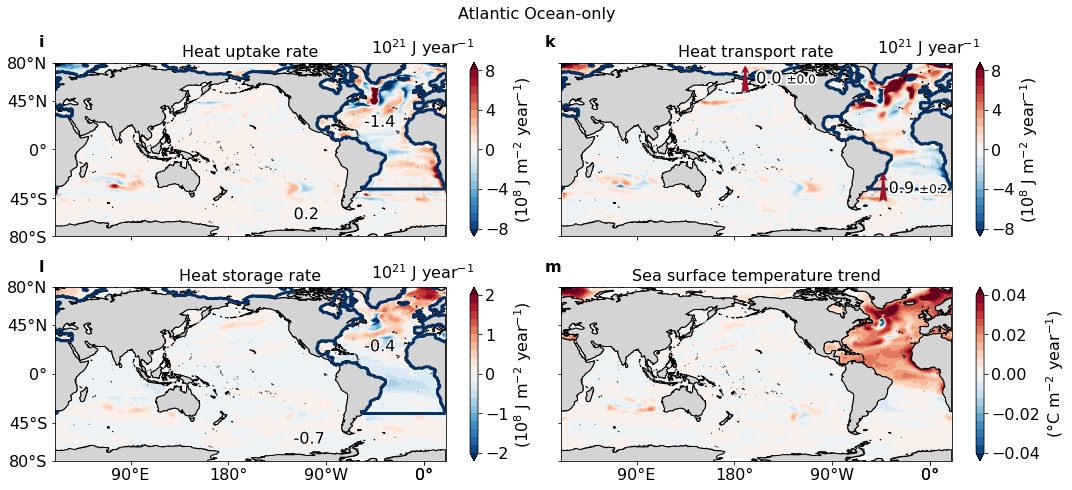

In [17]:
%%time   
plot_range = [-80,80]
farben = [[.83, .83, .83], rotblau[2], rotblau[6], rotblau[19], rotblau[15]]; farben2 = 'w'

# preparing the right contour for the experiment
if exp[1] == 'iaf_Pacific_PI_Offset': 
    contour = ds3.contour_pacific # outline for the panels
    #        PO    SO    PO   AO    IO
    lon = [-150, -120] # longitude where I plot the basin-wide value
    lat = [  20,  -60]  # latitude  "       "       "       "
    bars1_short = [bars1_iaf[3], bars1_iaf[0]-bars1_iaf[3]] # I only need a select few basin-wide values, 
                                                            # here for IAF_Pacific I need the Pacific value + the value outside the Pacific
                                                            # that is the global value - the Pacific value
    bars3_short = [bars3_iaf[3], bars3_iaf[0]-bars3_iaf[3]]
    # --- transects below here
    #      SO->PO, ITF, Bering
    lon2 = [ -153, -220, -160]; lat2 = [ -42,   5, 65]
    transects_iaf_short = [transects_iaf[1], transects_iaf[3], transects_iaf[4]] # only select transport across SO->IO and ITF, ...
    transects_volume_iaf_short = np.abs([transects_volume_iaf[1], transects_volume_iaf[3], transects_volume_iaf[4]]) # together with their uncertainties
if exp[1] == 'iaf_Indian_PI_Offset': 
    contour = ds3.contour_indian
    lon = [-310, -120]; lat = [  -5,  -60] 
    bars1_short = [bars1_iaf[4], bars1_iaf[0]-bars1_iaf[4]] # Indian Ocean value + (Global Ocean value - Indian Ocean value)
    bars3_short = [bars3_iaf[4], bars3_iaf[0]-bars3_iaf[4]]
    # --- transects below here
    #      SO->IO, ITF
    lon2 = [ -295, -220]; lat2 = [ -36,   5]
    transects_iaf_short = [transects_iaf[2], transects_iaf[3]] # only select transport across SO->IO and ITF, ...
    transects_volume_iaf_short = np.abs([transects_volume_iaf[2], transects_volume_iaf[3]]) # together with their uncertainties
if exp[1] == 'iaf_Atlantic_PI_Offset':
    contour = ds3.contour_atlantic
    lon = [-55, -120]; lat = [  25,  -60] 
    bars1_short = [bars1_iaf[5], bars1_iaf[0]-bars1_iaf[5]]
    bars3_short = [bars3_iaf[5], bars3_iaf[0]-bars3_iaf[5]]
    # --- transects below here
    #      SO->AO, Bering
    lon2 = [ -38, -160]; lat2 = [ -36,   65]
    transects_iaf_short = [transects_iaf[0], transects_iaf[4]] # only select transport across SO->AO and Bering Strait
    transects_volume_iaf_short = np.abs([transects_volume_iaf[0], transects_volume_iaf[4]])
if exp[1] in ['iaf_Southern_PI_Offset', 'iaf_Northern_PI_Offset']:
    contour = ds3.contour_southern 
    #        SO    PO    IO   AO
    lon = [-120, -150, -310, -55]; lat = [-60, 20, -5, 25] # lon & lat for basin-wide values
    bars1_short = [bars1_iaf[1], bars1_iaf[3], bars1_iaf[4], bars1_iaf[5]]
    bars3_short = [bars3_iaf[1], bars3_iaf[3], bars3_iaf[4], bars3_iaf[5]]
    # --- transects below here
    #      SO->AO, SO->PO, SO->IO, ITF, Bering
    lon2 = [-40, -153, -300, -220, -160]; lat2 = [ -36, -36, -36, 5, 65]
    transects_iaf_short = np.abs([transects_iaf[0], transects_iaf[1], transects_iaf[2], transects_iaf[3], transects_iaf[4]])
    transects_volume_iaf_short = np.abs([transects_volume_iaf[0], transects_volume_iaf[1], transects_volume_iaf[2], transects_volume_iaf[3], transects_volume_iaf[4]]) 

if exp[1] == 'iaf_Tropics30SN_PI_Offset': contour = ds3.contour_tropics
if exp[1] == 'iaf_Northern_PI_Offset': contour = ds3.contour_northern      
                             
print(exp[1])

# allocate all the data for plotting in this iteration
bars1 = bars1_iaf; bars2 = bars2_iaf; bars3 = bars3_iaf
filename= 'ACCESS-OM2-1_accumulated_OHC_and_net_sfc_heating_anomalies_1972-2017_' + exp[1]

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# initialise figure
fig = plt.figure(figsize=(15, 7),tight_layout=True,facecolor='w',edgecolor='k')
gs = gridspec.GridSpec(2, 2, width_ratios = [1,1]) 
# --------------------------------------------------------------------------- #
###       Plotting routine for the OHC vs. net_sfc_heating comparison       ###
# --------------------------------------------------------------------------- #

# --------------------------------------------------------------------------- #
# --- subplot 1: UPTAKE ----------------------------------------------------- #
# --------------------------------------------------------------------------- #

ticks = np.linspace(-8,8,num=21) # ticks for colour bar
# longitude starting at Cape Agulhas (20°E) so that I have Indian Ocean, Pacific Ocean, Atlantic Ocean without breaks
ax1 = plt.subplot(gs[0,0], projection=ccrs.PlateCarree(central_longitude=200))
ax1.set_extent([1, 360, plot_range[0], plot_range[1]], crs=ccrs.PlateCarree())

p1 = (Qnet_1deg_map/1e8).plot.contourf(cmp='RdBu_r',levels=ticks,add_colorbar=False,extend='both',transform=ccrs.PlateCarree())

# # ocean basin boundaries
if exp[1] in ['iaf_Tropics30SN_PI_Offset','iaf_Northern_PI_Offset']:
    plt.plot([-359, 0], [-36, -36],color = rotblau[20], linewidth=3, transform=ccrs.PlateCarree(),)
    plt.plot([142, 142], [-4,  -20], color = rotblau[20], linewidth=3, transform=ccrs.PlateCarree(),) # New Guinea to Arnhem Land line
    plt.plot([130, 142], [-8,  -8], color = rotblau[20], linewidth=3, transform=ccrs.PlateCarree(),) # New Guinea to Java
    plt.plot([10, 200], [65,  65], color = rotblau[20], linewidth=3, transform=ccrs.PlateCarree(),) # Bering Strait
else:
    p22 = contour.plot.contour(levels=[.8,1], linewidths=3, colors=[rotblau[20], rotblau[20]], transform=ccrs.PlateCarree())
    
plt.title('Heat uptake rate', fontsize=16) # title
ax1.text(-.04, 1.09,'i', transform=ax1.transAxes, size=16, weight='bold') # bold letter a at the top
fancy_plot(ax1); ax1.set_xticklabels([]) # overwrite x-axis tick (i.e. longitude) labels

# add colour bar   
cb = plt.colorbar(p1, shrink=.75, orientation='vertical'); 
cb.set_label(label='(10$^{8}$ J m$^{-2}$ year$^{-1}$)', size=16)
cb.ax.tick_params(labelsize=16); tick_locator = ticker.MaxNLocator(nbins=5)
cb.locator = tick_locator;cb.update_ticks()  


# # add basin-wide values
# #        SO    PO   AO    IO
# lon = [-120, -150, -55, -310] # longitude for Southern, Pacific, Atlantic and Indian Ocean
# lat = [-60,    20,  25,  -5] # latitude values
ax1.text(.81, 1.05, str('$10^{21}$ J year$^{-1}$'), transform=ax1.transAxes, size=16, weight='normal')
for s in range(len(lon)):          # round to certain number of digits as defined in cell above
    txt = plt.text(lon[s], lat[s], np.round(bars1_short[s],round_accuracy), verticalalignment='center',transform=ccrs.PlateCarree(), fontsize = 16)
    txt.set_path_effects([PathEffects.withStroke(linewidth=4, foreground='w')])    

    
    

# --------------------------------------------------------------------------- #
# --- subplot 1: TRANSPORT -------------------------------------------------- #
# --------------------------------------------------------------------------- #

ticks = np.linspace(-8,8,num=21) # ticks for colour bar
# longitude starting at Cape Agulhas (20°E) so that I have Indian Ocean, Pacific Ocean, Atlantic Ocean without breaks
ax1 = plt.subplot(gs[0,1], projection=ccrs.PlateCarree(central_longitude=200))
ax1.set_extent([1, 360, plot_range[0], plot_range[1]], crs=ccrs.PlateCarree())

p2 = ((OHC_1deg_map-Qnet_1deg_map)/1e8).plot.contourf(cmp='RdBu_r',levels=ticks,add_colorbar=False,extend='both',transform=ccrs.PlateCarree())

# # ocean basin boundaries
if exp[1] in ['iaf_Tropics30SN_PI_Offset','iaf_Northern_PI_Offset']:
    plt.plot([-359, 0], [-36, -36],color = rotblau[20], linewidth=3, transform=ccrs.PlateCarree(),)
    plt.plot([142, 142], [-4,  -20], color = rotblau[20], linewidth=3, transform=ccrs.PlateCarree(),) # New Guinea to Arnhem Land line
    plt.plot([130, 142], [-8,  -8], color = rotblau[20], linewidth=3, transform=ccrs.PlateCarree(),) # New Guinea to Java
    plt.plot([10, 200], [65,  65], color = rotblau[20], linewidth=3, transform=ccrs.PlateCarree(),) # Bering Strait
else:
    p22 = contour.plot.contour(levels=[.8,1], linewidths=3, colors=[rotblau[20], rotblau[20]], transform=ccrs.PlateCarree())

plt.title('Heat transport rate', fontsize=16) # title
ax1.text(-.04, 1.09,'k', transform=ax1.transAxes, size=16, weight='bold') # bold letter a at the top
fancy_plot(ax1); ax1.set_xticklabels([]);  ax1.set_yticklabels([]) # overwrite x-axis tick (i.e. longitude) labels

# add colour bar   
cb = plt.colorbar(p1, shrink=.75, orientation='vertical'); 
cb.set_label(label='(10$^{8}$ J m$^{-2}$ year$^{-1}$)', size=16)
cb.ax.tick_params(labelsize=16); tick_locator = ticker.MaxNLocator(nbins=5)
cb.locator = tick_locator;cb.update_ticks() 

labels = [item.get_text() for item in ax1.get_xticklabels()]
empty_string_labels = ['']*len(labels); ax1.set_xticklabels(empty_string_labels)

# label at the top right (str(np.round(bars2[0]*(-1),1))+)
ax1.text(.81, 1.05, str('$10^{21}$ J year$^{-1}$'), transform=ax1.transAxes, size=16, weight='normal')
#     for s in range(4):
#         txt = plt.text(lon[s], lat[s], np.round(bars2[s+1],round_accuracy)*(-1), verticalalignment='center',transform=ccrs.PlateCarree(), fontsize = 16)
#         txt.set_path_effects([PathEffects.withStroke(linewidth=2, foreground='w')])    

# arrows with values that indicate how much transport across the basins
if exp[1] in ['iaf_Indian_PI_Offset']:
    ax1.annotate('', xy=(-145, -20), xytext=(-145, -50),xycoords='data',
                 size=20,arrowprops=dict(facecolor=rotblau[2], ec = 'none',arrowstyle="fancy")) # arrow IO -> SO
if exp[1] in ['iaf_Indian_PI_Offset', 'iaf_Pacific_PI_Offset']:
    ax1.annotate('', xy=(-62, 6), xytext=(-82, -15),xycoords='data',
                 size=20,arrowprops=dict(facecolor=rotblau[2], ec = 'none',arrowstyle="fancy")) # arrow ITF
if exp[1] in ['iaf_Pacific_PI_Offset']:
    ax1.annotate('', xy=(0, -30), xytext=(0, -60),xycoords='data',
                 size=20,arrowprops=dict(facecolor=rotblau[2], ec = 'none',arrowstyle="fancy")) # arrow SO -> PO
if exp[1] in ['iaf_Atlantic_PI_Offset']:
    ax1.annotate('', xy=(117, -20), xytext=(117, -50),xycoords='data',
                 size=20,arrowprops=dict(facecolor=rotblau[2], ec = 'none',arrowstyle="fancy")) # arrow SO -> AO
if exp[1] in ['iaf_Atlantic_PI_Offset', 'iaf_Pacific_PI_Offset']:
    ax1.annotate('', xy=(-10, 79), xytext=(-10, 50),xycoords='data',
                 size=20,arrowprops=dict(facecolor=rotblau[2], ec = 'none',arrowstyle="fancy")) # arrow Bering Strait
if exp[1] in ['iaf_Southern_PI_Offset']:
    ax1.annotate('', xy=(0, -20), xytext=(0, -50),xycoords='data',
                 size=20,arrowprops=dict(facecolor=rotblau[2], ec = 'none',arrowstyle="fancy")) # arrow SO -> PO
    ax1.annotate('', xy=(-145, -20), xytext=(-145, -50),xycoords='data',
                 size=20,arrowprops=dict(facecolor=rotblau[2], ec = 'none',arrowstyle="fancy")) # arrow SO -> IO
    ax1.annotate('', xy=(117, -20), xytext=(117, -50),xycoords='data',
                 size=20,arrowprops=dict(facecolor=rotblau[2], ec = 'none',arrowstyle="fancy")) # arrow SO -> AO 
    ax1.annotate('', xy=(-82, -16), xytext=(-62, 6),xycoords='data',
            size=20,arrowprops=dict(facecolor=rotblau[2], ec = 'none',arrowstyle="fancy")) # arrow ITF
    ax1.annotate('', xy=(-10, 79), xytext=(-10, 50),xycoords='data',
            size=20,arrowprops=dict(facecolor=rotblau[2], ec = 'none',arrowstyle="fancy")) # arrow Bering Strait
if exp[1] in ['iaf_Northern_PI_Offset']:
    ax1.annotate('', xy=(0, -20), xytext=(0, -50),xycoords='data',
                 size=20,arrowprops=dict(facecolor=rotblau[2], ec = 'none',arrowstyle="fancy")) # arrow SO -> PO
    ax1.annotate('', xy=(-145, -50), xytext=(-145, -20),xycoords='data',
                 size=20,arrowprops=dict(facecolor=rotblau[2], ec = 'none',arrowstyle="fancy")) # arrow SO -> IO
    ax1.annotate('', xy=(117, -20), xytext=(117, -50),xycoords='data',
                 size=20,arrowprops=dict(facecolor=rotblau[2], ec = 'none',arrowstyle="fancy")) # arrow SO -> AO 
    ax1.annotate('', xy=(-62, 6), xytext=(-82, -16),xycoords='data',
            size=20,arrowprops=dict(facecolor=rotblau[2], ec = 'none',arrowstyle="fancy")) # arrow ITF
    ax1.annotate('', xy=(-10, 79), xytext=(-10, 50),xycoords='data',
            size=20,arrowprops=dict(facecolor=rotblau[2], ec = 'none',arrowstyle="fancy")) # arrow Bering Strait
    
#      SO->AO,   SO->PO, SO->IO,   ITF, Bering Indo-Pacific
# lon2 = [ -38,    -153,   -295,  -220,   -160, -225]
# lat2 = [ -35,     -35,    -35,     5,     65, -35]
for s in range(len(lon2)):
    txt = plt.text(lon2[s], lat2[s], transects_iaf_short[s], verticalalignment='center',transform=ccrs.PlateCarree(), fontsize = 16)
    txt.set_path_effects([PathEffects.withStroke(linewidth=4, foreground='w')])   
# now adding the uncertainty due to non net zero volume fluxes across the transects
for s in range(len(lon2)):
    txt = plt.text(lon2[s]+28, lat2[s]-1, r'$\pm$' + str(transects_volume_iaf_short[s]), verticalalignment='center',transform=ccrs.PlateCarree(), fontsize = 12)
    txt.set_path_effects([PathEffects.withStroke(linewidth=4, foreground='w')])   

    

# --------------------------------------------------------------------------- #
# --- subplot 3: STORAGE ---------------------------------------------------- #
# --------------------------------------------------------------------------- #

ticks = np.linspace(-2,2,num=21) # ticks for colour bar
# longitude starting at Cape Agulhas (20°E) so that I have Indian Ocean, Pacific Ocean, Atlantic Ocean without breaks
ax1 = plt.subplot(gs[1,0], projection=ccrs.PlateCarree(central_longitude=200))
ax1.set_extent([1, 360, plot_range[0], plot_range[1]], crs=ccrs.PlateCarree())

p2 = (OHC_1deg_map/1e8).plot.contourf(cmp='RdBu_r',levels=ticks,add_colorbar=False,extend='both',transform=ccrs.PlateCarree())

# # ocean basin boundaries
if exp[1] in ['iaf_Tropics30SN_PI_Offset','iaf_Northern_PI_Offset']:
    plt.plot([-359, 0], [-36, -36],color = rotblau[20], linewidth=3, transform=ccrs.PlateCarree(),)
    plt.plot([142, 142], [-4,  -20], color = rotblau[20], linewidth=3, transform=ccrs.PlateCarree(),) # New Guinea to Arnhem Land line
    plt.plot([130, 142], [-8,  -8], color = rotblau[20], linewidth=3, transform=ccrs.PlateCarree(),) # New Guinea to Java
    plt.plot([10, 200], [65,  65], color = rotblau[20], linewidth=3, transform=ccrs.PlateCarree(),) # Bering Strait
else:
    p22 = contour.plot.contour(levels=[.8,1], linewidths=3, colors=[rotblau[20], rotblau[20]], transform=ccrs.PlateCarree())

plt.title('Heat storage rate', fontsize=16) # title
ax1.text(-.04, 1.09,'l', transform=ax1.transAxes, size=16, weight='bold') # bold letter a at the top
fancy_plot(ax1)

ax1.text(.81, 1.05, str('$10^{21}$ J year$^{-1}$'), transform=ax1.transAxes, size=16, weight='normal')
for s in range(len(lon)):
    txt = plt.text(lon[s], lat[s], np.round(bars3_short[s],round_accuracy), verticalalignment='center',transform=ccrs.PlateCarree(), fontsize = 16)
    txt.set_path_effects([PathEffects.withStroke(linewidth=2, foreground='w')])    

# # add colour bar   
cb = plt.colorbar(p2, shrink=.75, orientation='vertical'); 
cb.set_label(label='(10$^{8}$ J m$^{-2}$ year$^{-1}$)', size=16)
cb.ax.tick_params(labelsize=16); tick_locator = ticker.MaxNLocator(nbins=4)
cb.locator = tick_locator;cb.update_ticks()  


# --------------------------------------------------------------------------- #
# --- subplot 3: SAT-SST Difference ----------------------------------------- #
# --------------------------------------------------------------------------- #

ticks = np.linspace(-.04,.04,num=21) # ticks for colour bar
# longitude starting at Cape Agulhas (20°E) so that I have Indian Ocean, Pacific Ocean, Atlantic Ocean without breaks
ax1 = plt.subplot(gs[1,1], projection=ccrs.PlateCarree(central_longitude=200))
ax1.set_extent([1, 360, plot_range[0], plot_range[1]], crs=ccrs.PlateCarree())

p2 = (SST_trend).plot.contourf(cmp='RdBu_r',levels=ticks,add_colorbar=False,extend='both',transform=ccrs.PlateCarree())

# ocean basin boundaries
plt.title('Sea surface temperature trend', fontsize=16) # title
ax1.text(-.04, 1.09,'m', transform=ax1.transAxes, size=16, weight='bold') # bold letter a at the top
fancy_plot(ax1); ax1.set_yticklabels([]) # overwrite x-axis tick (i.e. longitude) labels

# # add colour bar   
cb = plt.colorbar(p2, shrink=.75, orientation='vertical'); 
cb.set_label(label='(°C m$^{-2}$ year$^{-1}$)', size=16)
cb.ax.tick_params(labelsize=16); tick_locator = ticker.MaxNLocator(nbins=4)
cb.locator = tick_locator;cb.update_ticks() 
#     cb.add_lines(p22) # add contours to colour bar

plt.suptitle(supertitel, fontsize=16)

print('--- Globally integrated the redistribution term is: '+ str(bars2[0]*1e21) + ' which is two magnitudes smaller than the other terms')  
print('--- mention this in the manuscript')
# --------------------------------------------------------------------------- #
# --- saving as 300 dpi .PNG image in specified folder ---------------------- #
# --- end of script --------------------------------------------------------- #
plt.savefig(save + filename, 
            dpi=300, facecolor='w',
            edgecolor='w', orientation='landscape', papertype=None, 
            format=None, transparent=False, bbox_inches='tight', 
            pad_inches=0.1, metadata=None)
# --- end of script --------------------------------------------------------- #
# Wall time: 20.6 s

In [18]:
bars1_iaf

[array(-1.1834336),
 array(0.04808735),
 array(-1.23152095),
 array(0.03218949),
 array(0.14162142),
 array(-1.40847041),
 array(1.19301521),
 array(0.40184835),
 array(-2.77829716)]

### Quick map OHC in the TROPICS30SN simulation and trends only over 1992--2011

CPU times: user 5.77 s, sys: 488 ms, total: 6.26 s
Wall time: 6.88 s


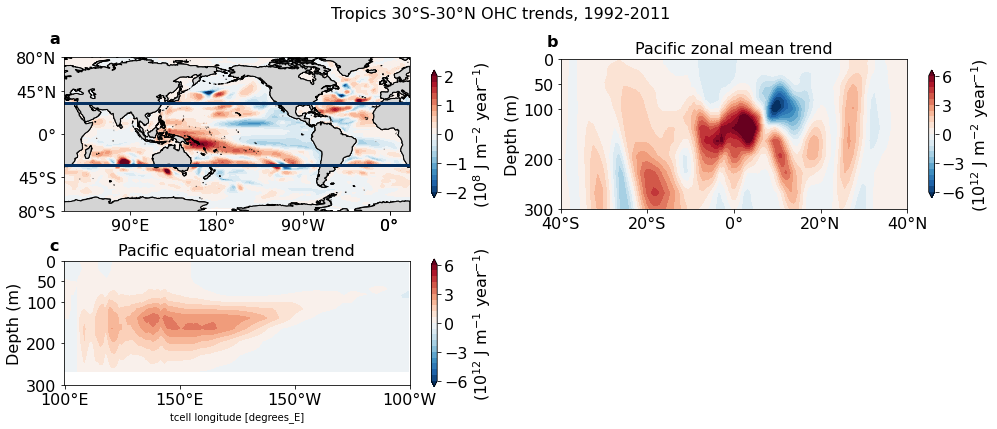

In [19]:
%%time
dzt = xr.open_mfdataset(base+run[0]+'output*/ocean/ocean.nc',decode_times=True).dzt.sel(time = slice('1972-01','2017-12')) 
area_t = xr.open_dataset(base+run[0]+'output200/ocean/ocean_grid.nc').area_t
dxt = xr.open_dataset(base+run[0]+'output200/ocean/ocean_grid.nc').dxt
dyt = xr.open_dataset(base+run[0]+'output200/ocean/ocean_grid.nc').dyt
rho_0 = 1035.0                       # [kg m^{-3}]
C_p = 3992.10322329649               # [J kg^{-1} K^{-1}]

# load in climatological temperature distribution as well
temp_clim_contour = xr.open_mfdataset(base+'1deg_jra55_rdf_branch2000_Control_PI_Offset/output*/ocean/ocean.nc').temp
temp_clim_contour1 = temp_clim_contour.mean(['time','xt_ocean']) - 273.15
temp_clim_contour2 = temp_clim_contour.mean(['time','yt_ocean']) - 273.15

temp_access = xr.open_dataset(base+out+'trend_temp_iaf_Tropics30SN_PI_Offset_1992-2011.nc').temp
OHC_1deg_map      = (rho_0*C_p*temp_access*dzt[0,:,:]).sum(['time','st_ocean']) # units of (J m-2 year-1)
OHC_1deg_depth    = (rho_0*C_p*temp_access*dxt).isel(xt_ocean=slice(29,180)).sum(['time', 'xt_ocean']) # units of (J m-1 year-1)
# equatorial mean 5°S-5°N, and upper 300 m and across the Pacific 100°E-100°W
OHC_1deg_equa     = (rho_0*C_p*temp_access*dxt).isel(yt_ocean=slice(121,153)).isel(xt_ocean=slice(29,180)).sum(['time','yt_ocean']).sel(st_ocean=slice(0,300))
# Wall time: 665 ms

    
plot_range = [-80,78]
ticks = np.linspace(-8,8,num=21) # ticks for colour bar
      
# initialise figure
fig = plt.figure(figsize=(14,6),tight_layout=True,facecolor='w',edgecolor='k')
gs = gridspec.GridSpec(2,2)#, height_ratios=[1,1,1]) 

# --------------------------------------------------------------------------- #
# --- subplot 1: IAF_TROPICS30SN -------------------------------------------- #
# --------------------------------------------------------------------------- #

ax1 = plt.subplot(gs[0,0], projection=ccrs.PlateCarree(central_longitude=201)) # longitude starting at Cape Agulhas (20°E) 

ticks = np.linspace(-2,2,num=21) # ticks for colour bar
ax1.set_extent([1, 360, plot_range[0], plot_range[1]], crs=ccrs.PlateCarree())
# plot the data
p1 = (OHC_1deg_map/1e8).plot.contourf(cmp='RdBu_r',levels=ticks, add_colorbar=False,extend='both',transform=ccrs.PlateCarree())

ax1.text(-.04, 1.09,'a', transform=ax1.transAxes, size=16, weight='bold') # bold letter a at the top
fancy_plot(ax1) # add land boundaries, fill in land and add labels in °S/°N form
ax1.add_feature(cfeature.LAND, edgecolor = 'black', facecolor = [.83,.83,.83], zorder = 1)
# # add colour bar   
cb = plt.colorbar(p1, shrink=.8, orientation='vertical'); 
cb.set_label(label='(10$^{8}$ J m$^{-2}$ year$^{-1}$)', size=16)
cb.ax.tick_params(labelsize=16); tick_locator = ticker.MaxNLocator(nbins=4)
cb.locator = tick_locator;cb.update_ticks() 
plt.plot([-359, 0], [-32, -32],color = rotblau[20], linewidth=3, transform=ccrs.PlateCarree(),)
plt.plot([-359, 0], [32, 32],color = rotblau[20], linewidth=3, transform=ccrs.PlateCarree(),)

# --------------------------------------------------------------------------- #
# --- subplot 2: IAF_TROPICS30SN Depth-Latitude ----------------------------- #
# --------------------------------------------------------------------------- #
def fancy_plot2(axes_nr): # different function for the zonally-integrated depth-latitude plots
    axes_nr.tick_params(axis='both', which='major', labelsize=16) # fontsize of lon/lat labels
    plt.gca().invert_yaxis() # reverse y axis so it goes from surface (0 m) down to 2000 m 
    axes_nr.set_ylim([300,0]); axes_nr.set_xlim([-40,40]) # set plot limits
    axes_nr.set_xticks([-40,-20,0,20,40])
    axes_nr.set_yticks([300, 200, 100, 50, 0])

    lat_formatter = cticker.LatitudeFormatter()
    axes_nr.xaxis.set_major_formatter(lat_formatter) # "       "       "
    axes_nr.xaxis.label.set_visible(False) # no axis labels
    plt.ylabel('Depth (m)', fontsize=16)
    
ax1 = plt.subplot(gs[0,1], aspect = .115) # longitude starting at Cape Agulhas (20°E) 

# plot the data
ticks = np.linspace(-6,6,num=21) # ticks for colour bar

p2 = (OHC_1deg_depth/1e12).plot.contourf(cmp='RdBu_r',levels=ticks, add_colorbar=False,extend='both')

# p11 = (OHC_1deg_depth/1e12).plot.contour(levels = [-6,-3,0,3,6],linewidths=1.0, colors='grey',interpolation='none')
# p22 = temp_clim_contour1.plot.contour(levels = [15,17,19,21,23,25,27,29],linewidths=1.0, colors='k',interpolation='none')
plt.clabel(p22, inline_spacing=1, fontsize=16, fmt="%.1i")
plt.title('Pacific zonal mean trend', fontsize=16) # title
fancy_plot2(ax1)
ax1.text(-.04, 1.09,'b', transform=ax1.transAxes, size=16, weight='bold') # bold letter a at the top
# # add colour bar   
cb = plt.colorbar(p2, shrink=.8, orientation='vertical'); 
cb.set_label(label='(10$^{12}$ J m$^{-2}$ year$^{-1}$)', size=16)
cb.ax.tick_params(labelsize=16); tick_locator = ticker.MaxNLocator(nbins=4)
cb.locator = tick_locator;cb.update_ticks() 
plt.plot([0,300], [-32, -32],color = rotblau[20], linewidth=3)

# --------------------------------------------------------------------------- #
# --- subplot 2: IAF_TROPICS30SN Depth-Latitude ----------------------------- #
# --------------------------------------------------------------------------- #
ax1 = plt.subplot(gs[1,0], aspect =.18) # longitude starting at Cape Agulhas (20°E) 
    
p3 = (OHC_1deg_equa/1e12).plot.contourf(cmp='RdBu_r',levels=ticks, add_colorbar=False,extend='both')

plt.clabel(p22, inline_spacing=1, fontsize=16, fmt="%.1i")
plt.title('Pacific equatorial mean trend', fontsize=16) # title
# fancy_plot3(ax1)
ax1.text(-.04, 1.09,'c', transform=ax1.transAxes, size=16, weight='bold') # bold letter a at the top
# # add colour bar   
cb = plt.colorbar(p2, shrink=.8, orientation='vertical'); 
cb.set_label(label='(10$^{12}$ J m$^{-1}$ year$^{-1}$)', size=16)
cb.ax.tick_params(labelsize=16); tick_locator = ticker.MaxNLocator(nbins=4)
cb.locator = tick_locator;cb.update_ticks() 
ax1.tick_params(axis='both', which='major', labelsize=16); plt.ylabel('Depth (m)', fontsize=16)    
ax1.set_ylim([0,300]); ax1.set_yticks([0,50,100,200,300]); ax1.set_xticks([-250,-200,-150,-100]) # 100°E-100°W
plt.gca().invert_yaxis() # reverse y axis so it goes from surface (0 m) down to 2000 m 

labels = [item.get_text() for item in ax1.get_xticklabels()]
labels =       ['100°E', '150°E', '150°W', '100°W']; ax1.set_xticklabels(labels)

# ax1.set_xticks([-360,-270,-180,-90,0]) 
plt.suptitle('Tropics 30°S-30°N OHC trends, 1992-2011', fontsize=16)

# --------------------------------------------------------------------------- #
# --- saving as 300 dpi .PNG image in specified folder ---------------------- #
# --- end of script --------------------------------------------------------- #
plt.savefig(save + 'Tropics30SN_1992-2011_trends_with_equatorial_transects_depth', 
            dpi=300, facecolor='w',
            edgecolor='w', orientation='landscape', papertype=None, 
            format=None, transparent=False, bbox_inches='tight', 
            pad_inches=0.1, metadata=None)
# --- end of script --------------------------------------------------------- #
# Wall time: 

In [ ]:
# ----------------------------------------------------------------------------------------------------------------------- #
#                                                   Notes down below                                                      #
# ----------------------------------------------------------------------------------------------------------------------- #